In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-12-08 15:02:34.752846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
image_path='/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/Images/*'
images=glob(image_path + "*.jpg")
print("Total Images in Dataset = {}".format(len(images)))

Total Images in Dataset = 8091


## Visualize the data

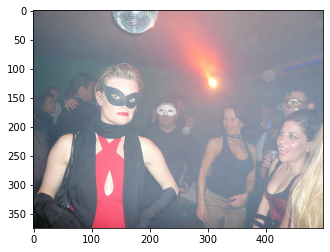

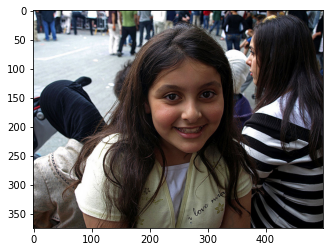

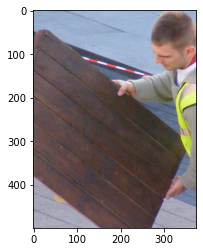

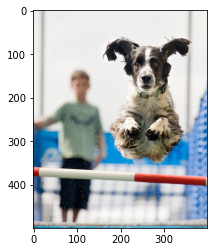

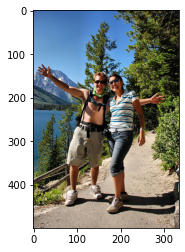

In [4]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

## Pre-processing the Images:

In [5]:
from tensorflow.keras.applications import VGG16

#load vgg16 model
model = VGG16()
#restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [62]:
#extract features from image
images_folder = '/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/Images'
features = {}

for img_name in tqdm(os.listdir(images_folder)):
    #load image from file
    img_path = images_folder + '/' + img_name
    image = load_img(img_path, target_size=(224,224))
    #convert image pixels to numpy array
    image = img_to_array(image)
    #reshape data for the model
    image=image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    #preprocess image for VGG
    image = preprocess_input(image)
    #extract features
    feature = model.predict(image, verbose=0)
    #get image ID
    image_id = img_name.split('.')[0]
    #store feature
    features[image_id] = feature

  0%|                                                  | 0/8091 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
100%|███████████████████████████████████████| 8091/8091 [45:20<00:00,  2.97it/s]


In [63]:
import pickle

# Save the features in the images1 pickle file
with open("image_features.pkl", "wb") as encoded_pickle:
    pickle.dump(features, encoded_pickle)

In [10]:
import pickle

# Specify the path to your pickle file
picklefile_path = 'image_features.pkl'

# Open the pickle file for reading in binary mode
with open(picklefile_path, 'rb') as file:
    # Load the data from the pickle file
    features = pickle.load(file)
    
features['2387197355_237f6f41ee']

array([[0.8718654, 0.       , 0.       , ..., 0.3054284, 0.       ,
        2.0037658]], dtype=float32)

## Pre-processing the text data:

In [12]:
def read_captions(filename):
    with open(filename, 'rb') as f:
        next(f)  # To remove the 1st line "Image, captions"
        cap_doc = f.read().decode('utf-8').split('\n')
    return cap_doc

# Example usage:
file_path = '/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/captions.txt'
info = read_captions(file_path)
print(info[:10])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .', '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .', '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .', '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting', '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .', '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .', '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .', '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .']


In [13]:
def load_captions(info):
    dict_1 = dict()
    for line in info:
        parts = line.split(',', 1)  # Split on the first comma to separate image_id and caption
        if len(parts) == 2:
            image_id, caption = parts
            image_id = image_id.strip().split('.')[0]  # Extract the image ID without the file extension
            
            if image_id not in dict_1:
                dict_1[image_id] = list()
                
            dict_1[image_id].append(caption)
        
    return dict_1

data = load_captions(info)
print("Total Images in Dataset = {}".format(len(data)))


# Print the first 2 keys and their values
for i, (image_id, captions) in enumerate(data.items()):
    print(f"Image ID: {image_id}")
    print("Captions:")
    for caption in captions:
        print(f" {caption}")
    print()

    if i == 1:
        break

Total Images in Dataset = 8091
Image ID: 1000268201_693b08cb0e
Captions:
 A child in a pink dress is climbing up a set of stairs in an entry way .
 A girl going into a wooden building .
 A little girl climbing into a wooden playhouse .
 A little girl climbing the stairs to her playhouse .
 A little girl in a pink dress going into a wooden cabin .

Image ID: 1001773457_577c3a7d70
Captions:
 A black dog and a spotted dog are fighting
 A black dog and a tri-colored dog playing with each other on the road .
 A black dog and a white dog with brown spots are staring at each other in the street .
 Two dogs of different breeds looking at each other on the road .
 Two dogs on pavement moving toward each other .



In [14]:
# Cleanse and pre-process the data
def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            
            # Add startseq at the beginning
            lines += "startseq "
            
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            
            # Add endseq at the end
            lines += "endseq"
            
            if key not in dict_2:
                dict_2[key] = list()
            
            dict_2[key].append(lines)
            
    return dict_2

data2 = cleanse_data(data)
print(len(data2)) 

# Print the first 2 keys and their values
for i, (image_id, captions) in enumerate(data2.items()):
    print(f"Image ID: {image_id}")
    print("Cleaned Captions:")
    for caption in captions:
        print(f" {caption}")
    print()

    if i == 1:
        break

8091
Image ID: 1000268201_693b08cb0e
Cleaned Captions:
 startseq child in pink dress is climbing up set of stairs in an entry way endseq
 startseq girl going into wooden building endseq
 startseq little girl climbing into wooden playhouse endseq
 startseq little girl climbing the stairs to her playhouse endseq
 startseq little girl in pink dress going into wooden cabin endseq

Image ID: 1001773457_577c3a7d70
Cleaned Captions:
 startseq black dog and spotted dog are fighting endseq
 startseq black dog and tri-colored dog playing with each other on the road endseq
 startseq black dog and white dog with brown spots are staring at each other in the street endseq
 startseq two dogs of different breeds looking at each other on the road endseq
 startseq two dogs on pavement moving toward each other endseq



In [15]:
clean_captions = []
for key in data2:
    for caption in data2[key]:
        clean_captions.append(caption)
        
len(clean_captions)

40455

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

# tokenize the text
tokenizer =  Tokenizer()
tokenizer.fit_on_texts(clean_captions)
vocab_size = len(tokenizer.word_index)+1

#get maximum length of the caption
max_length = max(len(caption.split()) for caption in clean_captions)

max_length

35

## Train-Validation-Test Partition

In [46]:
from sklearn.model_selection import train_test_split


image_ids = list(data2.keys())
sequences = list(data2.values())

# Split the data into train (80%), val (10%), and test (10%)
train_ids, temp_ids, train_seqs, temp_seqs = train_test_split(image_ids, sequences, test_size=0.2, random_state=42)
val_ids, test_ids, val_seqs, test_seqs = train_test_split(temp_ids, temp_seqs, test_size=0.5, random_state=42)

# Now WE have train_ids, train_seqs, val_ids, val_seqs, test_ids, test_seqs
# which represent the image IDs and sequences for the train, val, and test sets respectively

# Create dictionaries for train, val, and test data
train_data = dict(zip(train_ids, train_seqs))
val_data = dict(zip(val_ids, val_seqs))
test_data = dict(zip(test_ids, test_seqs))

# Create a mapping from image IDs in data2 to features
id_mapping = {image_id: image_id for image_id in data2.keys()}

# Create new dictionaries for train, val, and test features
train_features = {id_mapping[image_id]: features[image_id] for image_id in train_ids}
val_features = {id_mapping[image_id]: features[image_id] for image_id in val_ids}
test_features = {id_mapping[image_id]: features[image_id] for image_id in test_ids}

# Now train_features, val_features, and test_features contain the image IDs with consistent keys
# and their corresponding features

## Creating Our Data Loader:

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, data2, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while(1):
        for key in data_keys:
            n+=1
            captions = data2[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq=tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model

In [23]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 35)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2172160   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                            

## Training & Evaluation

### For epochs = 10

In [24]:
# train the model
epochs =10
batch_size = 32
# Calculate steps for both training and validation sets
train_steps = len(train_data) // batch_size
val_steps = len(val_data) // batch_size

# Training loop
for i in range(epochs):
    # Create data generators for training and validation
    train_generator = data_generator(train_ids, train_data, train_features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = data_generator(val_ids, val_data, val_features, tokenizer, max_length, vocab_size, batch_size)
    
    # Fit for one epoch with validation
    model.fit(train_generator, epochs=1, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, verbose=1)


202/202 [==============================] - 371s 2s/step - loss: 2.5909 - val_loss: 4.1364


In [26]:
def idx_to_word(integer, tokenizer):
    # Assuming tokenizer has a reverse mapping from index to word
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    
    return reverse_word_index.get(integer, None)

def word_to_idx(word, tokenizer):
    # Assuming tokenizer has a word-to-index mapping
    word_index = tokenizer.word_index
    
    return word_index.get(word, None)

### Greedy Search to Predict Next Word

In [27]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = data2[key]
    # predict the caption for image
    y_pred = predict_caption(model, test_features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|█████████████████████████████████████████| 810/810 [07:34<00:00,  1.78it/s]

BLEU-1: 0.552128


### That is, 56% percentage of the words in the generated caption match those in the reference caption using Greedy Search.

### Beam Search to Predict Next Word

In [182]:
def beam_search_predictions(model, image_feature, tokenizer, max_length, beam_index=3):
    start_token = 'startseq'
    end_token = 'endseq'

    start = [tokenizer.word_index[start_token]]
    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_length)
            preds = model.predict([image_feature, sequence])
            word_preds = np.argsort(preds[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-beam_index:]

    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.index_word[i] for i in start_word]

    final_caption = []

    for i in intermediate_caption:
        if i != end_token:
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [184]:
# Example usage in your loop
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = data2[key]
    image_feature = test_features[key]
    
    # Use beam_search_predictions with appropriate arguments
    y_pred = beam_search_predictions(model, image_feature, tokenizer, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))


  0%|                                                   | 0/810 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  0%|                                         | 1/810 [00:06<1:34:12,  6.99s/it]

1/1 [==============================] - 0s 21ms/step


  0%|                                         | 2/810 [00:13<1:30:40,  6.73s/it]

1/1 [==============================] - 0s 20ms/step


  0%|▏                                        | 3/810 [00:19<1:28:11,  6.56s/it]

1/1 [==============================] - 0s 21ms/step


  0%|▏                                        | 4/810 [00:26<1:26:45,  6.46s/it]

1/1 [==============================] - 0s 21ms/step


  1%|▎                                        | 5/810 [00:32<1:26:10,  6.42s/it]

1/1 [==============================] - 0s 22ms/step


  1%|▎                                        | 6/810 [00:38<1:25:09,  6.36s/it]

1/1 [==============================] - 0s 33ms/step


  1%|▎                                        | 7/810 [00:45<1:25:07,  6.36s/it]

1/1 [==============================] - 0s 25ms/step


  1%|▍                                        | 8/810 [00:55<1:40:18,  7.50s/it]

1/1 [==============================] - 0s 21ms/step


  1%|▍                                        | 9/810 [01:02<1:40:49,  7.55s/it]

1/1 [==============================] - 0s 23ms/step


  1%|▍                                       | 10/810 [01:09<1:36:12,  7.22s/it]

1/1 [==============================] - 0s 21ms/step


  1%|▌                                       | 11/810 [01:15<1:32:14,  6.93s/it]

1/1 [==============================] - 0s 23ms/step


  1%|▌                                       | 12/810 [01:21<1:30:01,  6.77s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▋                                       | 13/810 [01:28<1:28:32,  6.67s/it]

1/1 [==============================] - 0s 28ms/step


  2%|▋                                       | 14/810 [01:34<1:26:53,  6.55s/it]

1/1 [==============================] - 0s 21ms/step


  2%|▋                                       | 15/810 [01:40<1:25:48,  6.48s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▊                                       | 16/810 [01:47<1:24:57,  6.42s/it]

1/1 [==============================] - 0s 22ms/step


  2%|▊                                       | 17/810 [01:54<1:26:45,  6.56s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▉                                       | 18/810 [02:00<1:25:02,  6.44s/it]

1/1 [==============================] - 0s 26ms/step


  2%|▉                                       | 19/810 [02:06<1:25:56,  6.52s/it]

1/1 [==============================] - 0s 24ms/step


  2%|▉                                       | 20/810 [02:13<1:25:21,  6.48s/it]

1/1 [==============================] - 0s 21ms/step


  3%|█                                       | 21/810 [02:19<1:25:02,  6.47s/it]

1/1 [==============================] - 0s 21ms/step


  3%|█                                       | 22/810 [02:25<1:23:33,  6.36s/it]

1/1 [==============================] - 0s 22ms/step


  3%|█▏                                      | 23/810 [02:32<1:22:50,  6.32s/it]

1/1 [==============================] - 0s 21ms/step


  3%|█▏                                      | 24/810 [02:38<1:21:28,  6.22s/it]

1/1 [==============================] - 0s 20ms/step


  3%|█▏                                      | 25/810 [02:44<1:22:59,  6.34s/it]

1/1 [==============================] - 0s 19ms/step


  3%|█▎                                      | 26/810 [02:50<1:20:38,  6.17s/it]

1/1 [==============================] - 0s 24ms/step


  3%|█▎                                      | 27/810 [02:57<1:23:31,  6.40s/it]

1/1 [==============================] - 0s 21ms/step


  3%|█▍                                      | 28/810 [03:04<1:25:54,  6.59s/it]

1/1 [==============================] - 0s 20ms/step


  4%|█▍                                      | 29/810 [03:10<1:24:30,  6.49s/it]

1/1 [==============================] - 0s 22ms/step


  4%|█▍                                      | 30/810 [03:17<1:23:33,  6.43s/it]

1/1 [==============================] - 0s 20ms/step


  4%|█▌                                      | 31/810 [03:23<1:21:54,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


  4%|█▌                                      | 32/810 [03:29<1:21:08,  6.26s/it]

1/1 [==============================] - 0s 20ms/step


  4%|█▋                                      | 33/810 [03:35<1:21:43,  6.31s/it]

1/1 [==============================] - 0s 20ms/step


  4%|█▋                                      | 34/810 [03:41<1:20:19,  6.21s/it]

1/1 [==============================] - 0s 21ms/step


  4%|█▋                                      | 35/810 [03:47<1:18:59,  6.12s/it]

1/1 [==============================] - 0s 20ms/step


  4%|█▊                                      | 36/810 [03:53<1:18:15,  6.07s/it]

1/1 [==============================] - 0s 20ms/step


  5%|█▊                                      | 37/810 [03:59<1:16:56,  5.97s/it]

1/1 [==============================] - 0s 20ms/step


  5%|█▉                                      | 38/810 [04:05<1:16:31,  5.95s/it]

1/1 [==============================] - 0s 21ms/step


  5%|█▉                                      | 39/810 [04:10<1:15:55,  5.91s/it]

1/1 [==============================] - 0s 21ms/step


  5%|█▉                                      | 40/810 [04:16<1:15:05,  5.85s/it]

1/1 [==============================] - 0s 20ms/step


  5%|██                                      | 41/810 [04:22<1:15:40,  5.90s/it]

1/1 [==============================] - 0s 21ms/step


  5%|██                                      | 42/810 [04:28<1:15:38,  5.91s/it]

1/1 [==============================] - 0s 21ms/step


  5%|██                                      | 43/810 [04:34<1:17:14,  6.04s/it]

1/1 [==============================] - 0s 22ms/step


  5%|██▏                                     | 44/810 [04:41<1:18:35,  6.16s/it]

1/1 [==============================] - 0s 21ms/step


  6%|██▏                                     | 45/810 [04:47<1:18:25,  6.15s/it]

1/1 [==============================] - 0s 20ms/step


  6%|██▎                                     | 46/810 [04:53<1:17:47,  6.11s/it]

1/1 [==============================] - 0s 21ms/step


  6%|██▎                                     | 47/810 [04:59<1:17:15,  6.08s/it]

1/1 [==============================] - 0s 21ms/step


  6%|██▎                                     | 48/810 [05:05<1:17:41,  6.12s/it]

1/1 [==============================] - 0s 22ms/step


  6%|██▍                                     | 49/810 [05:11<1:17:25,  6.10s/it]

1/1 [==============================] - 0s 20ms/step


  6%|██▍                                     | 50/810 [05:17<1:17:38,  6.13s/it]

1/1 [==============================] - 0s 20ms/step


  6%|██▌                                     | 51/810 [05:24<1:19:23,  6.28s/it]

1/1 [==============================] - 0s 25ms/step


  6%|██▌                                     | 52/810 [05:31<1:20:01,  6.33s/it]

1/1 [==============================] - 0s 23ms/step


  7%|██▌                                     | 53/810 [05:37<1:19:02,  6.26s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▋                                     | 54/810 [05:43<1:19:29,  6.31s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▋                                     | 55/810 [05:49<1:17:23,  6.15s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▊                                     | 56/810 [05:55<1:15:40,  6.02s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▊                                     | 57/810 [06:00<1:14:33,  5.94s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▊                                     | 58/810 [06:06<1:14:20,  5.93s/it]

1/1 [==============================] - 0s 20ms/step


  7%|██▉                                     | 59/810 [06:13<1:16:35,  6.12s/it]

1/1 [==============================] - 0s 23ms/step


  7%|██▉                                     | 60/810 [06:20<1:18:52,  6.31s/it]

1/1 [==============================] - 0s 57ms/step


  8%|███                                     | 61/810 [06:27<1:21:08,  6.50s/it]

1/1 [==============================] - 0s 25ms/step


  8%|███                                     | 62/810 [06:34<1:23:19,  6.68s/it]

1/1 [==============================] - 0s 20ms/step


  8%|███                                     | 63/810 [06:40<1:21:24,  6.54s/it]

1/1 [==============================] - 0s 21ms/step


  8%|███▏                                    | 64/810 [06:46<1:21:05,  6.52s/it]

1/1 [==============================] - 0s 21ms/step


  8%|███▏                                    | 65/810 [06:53<1:20:02,  6.45s/it]

1/1 [==============================] - 0s 21ms/step


  8%|███▎                                    | 66/810 [06:59<1:19:10,  6.39s/it]

1/1 [==============================] - 0s 21ms/step


  8%|███▎                                    | 67/810 [07:05<1:18:50,  6.37s/it]

1/1 [==============================] - 0s 22ms/step


  8%|███▎                                    | 68/810 [07:12<1:21:47,  6.61s/it]

1/1 [==============================] - 0s 22ms/step


  9%|███▍                                    | 69/810 [07:19<1:20:37,  6.53s/it]

1/1 [==============================] - 0s 23ms/step


  9%|███▍                                    | 70/810 [07:26<1:22:20,  6.68s/it]

1/1 [==============================] - 0s 26ms/step


  9%|███▌                                    | 71/810 [07:33<1:25:57,  6.98s/it]

1/1 [==============================] - 0s 21ms/step


  9%|███▌                                    | 72/810 [07:40<1:23:45,  6.81s/it]

1/1 [==============================] - 0s 21ms/step


  9%|███▌                                    | 73/810 [07:46<1:22:11,  6.69s/it]

1/1 [==============================] - 0s 21ms/step


  9%|███▋                                    | 74/810 [07:53<1:22:29,  6.72s/it]

1/1 [==============================] - 0s 20ms/step


  9%|███▋                                    | 75/810 [08:00<1:22:04,  6.70s/it]

1/1 [==============================] - 0s 30ms/step


  9%|███▊                                    | 76/810 [08:07<1:25:18,  6.97s/it]

1/1 [==============================] - 0s 21ms/step


 10%|███▊                                    | 77/810 [08:17<1:34:46,  7.76s/it]

1/1 [==============================] - 0s 23ms/step


 10%|███▊                                    | 78/810 [08:25<1:36:30,  7.91s/it]

1/1 [==============================] - 0s 45ms/step


 10%|███▉                                    | 79/810 [08:34<1:38:56,  8.12s/it]

1/1 [==============================] - 0s 22ms/step


 10%|███▉                                    | 80/810 [08:41<1:34:24,  7.76s/it]

1/1 [==============================] - 0s 24ms/step


 10%|████                                    | 81/810 [08:47<1:28:56,  7.32s/it]

1/1 [==============================] - 0s 22ms/step


 10%|████                                    | 82/810 [08:53<1:25:33,  7.05s/it]

1/1 [==============================] - 0s 21ms/step


 10%|████                                    | 83/810 [09:00<1:23:16,  6.87s/it]

1/1 [==============================] - 0s 29ms/step


 10%|████▏                                   | 84/810 [09:07<1:23:55,  6.94s/it]

1/1 [==============================] - 0s 25ms/step


 10%|████▏                                   | 85/810 [09:14<1:24:50,  7.02s/it]

1/1 [==============================] - 0s 21ms/step


 11%|████▏                                   | 86/810 [09:21<1:23:28,  6.92s/it]

1/1 [==============================] - 0s 21ms/step


 11%|████▎                                   | 87/810 [09:27<1:21:56,  6.80s/it]

1/1 [==============================] - 0s 20ms/step


 11%|████▎                                   | 88/810 [09:34<1:19:44,  6.63s/it]

1/1 [==============================] - 0s 24ms/step


 11%|████▍                                   | 89/810 [09:40<1:18:28,  6.53s/it]

1/1 [==============================] - 0s 21ms/step


 11%|████▍                                   | 90/810 [09:46<1:17:27,  6.46s/it]

1/1 [==============================] - 0s 26ms/step


 11%|████▍                                   | 91/810 [09:53<1:17:59,  6.51s/it]

1/1 [==============================] - 0s 23ms/step


 11%|████▌                                   | 92/810 [10:00<1:19:51,  6.67s/it]

1/1 [==============================] - 0s 26ms/step


 11%|████▌                                   | 93/810 [10:06<1:19:40,  6.67s/it]

1/1 [==============================] - 0s 24ms/step


 12%|████▋                                   | 94/810 [10:13<1:18:50,  6.61s/it]

1/1 [==============================] - 0s 24ms/step


 12%|████▋                                   | 95/810 [10:20<1:19:44,  6.69s/it]

1/1 [==============================] - 0s 21ms/step


 12%|████▋                                   | 96/810 [10:26<1:17:47,  6.54s/it]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                   | 97/810 [10:32<1:16:26,  6.43s/it]

1/1 [==============================] - 0s 21ms/step


 12%|████▊                                   | 98/810 [10:38<1:15:29,  6.36s/it]

1/1 [==============================] - 0s 21ms/step


 12%|████▉                                   | 99/810 [10:45<1:14:42,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 12%|████▊                                  | 100/810 [10:51<1:13:48,  6.24s/it]

1/1 [==============================] - 0s 23ms/step


 12%|████▊                                  | 101/810 [10:57<1:13:21,  6.21s/it]

1/1 [==============================] - 0s 23ms/step


 13%|████▉                                  | 102/810 [11:03<1:12:36,  6.15s/it]

1/1 [==============================] - 0s 21ms/step


 13%|████▉                                  | 103/810 [11:09<1:12:17,  6.13s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█████                                  | 104/810 [11:15<1:12:27,  6.16s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█████                                  | 105/810 [11:21<1:11:52,  6.12s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█████                                  | 106/810 [11:27<1:11:41,  6.11s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█████▏                                 | 107/810 [11:33<1:11:15,  6.08s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█████▏                                 | 108/810 [11:40<1:12:24,  6.19s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█████▏                                 | 109/810 [11:47<1:15:16,  6.44s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█████▎                                 | 110/810 [11:53<1:15:06,  6.44s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█████▎                                 | 111/810 [11:59<1:14:38,  6.41s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█████▍                                 | 112/810 [12:06<1:15:54,  6.53s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█████▍                                 | 113/810 [12:12<1:13:57,  6.37s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█████▍                                 | 114/810 [12:18<1:12:57,  6.29s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█████▌                                 | 115/810 [12:25<1:12:26,  6.25s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█████▌                                 | 116/810 [12:31<1:12:06,  6.23s/it]

1/1 [==============================] - 0s 20ms/step


 14%|█████▋                                 | 117/810 [12:37<1:11:53,  6.23s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█████▋                                 | 118/810 [12:43<1:11:23,  6.19s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█████▋                                 | 119/810 [12:49<1:11:05,  6.17s/it]

1/1 [==============================] - 0s 19ms/step


 15%|█████▊                                 | 120/810 [12:55<1:11:06,  6.18s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█████▊                                 | 121/810 [13:02<1:11:22,  6.22s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█████▊                                 | 122/810 [13:08<1:11:12,  6.21s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█████▉                                 | 123/810 [13:14<1:10:23,  6.15s/it]

1/1 [==============================] - 0s 20ms/step


 15%|█████▉                                 | 124/810 [13:20<1:10:02,  6.13s/it]

1/1 [==============================] - 0s 23ms/step


 15%|██████                                 | 125/810 [13:26<1:09:54,  6.12s/it]

1/1 [==============================] - 0s 24ms/step


 16%|██████                                 | 126/810 [13:32<1:09:51,  6.13s/it]

1/1 [==============================] - 0s 22ms/step


 16%|██████                                 | 127/810 [13:38<1:09:36,  6.12s/it]

1/1 [==============================] - 0s 22ms/step


 16%|██████▏                                | 128/810 [13:45<1:10:05,  6.17s/it]

1/1 [==============================] - 0s 20ms/step


 16%|██████▏                                | 129/810 [13:51<1:11:04,  6.26s/it]

1/1 [==============================] - 0s 21ms/step


 16%|██████▎                                | 130/810 [13:57<1:09:20,  6.12s/it]

1/1 [==============================] - 0s 20ms/step


 16%|██████▎                                | 131/810 [14:03<1:09:14,  6.12s/it]

1/1 [==============================] - 0s 20ms/step


 16%|██████▎                                | 132/810 [14:09<1:09:06,  6.12s/it]

1/1 [==============================] - 0s 21ms/step


 16%|██████▍                                | 133/810 [14:15<1:09:07,  6.13s/it]

1/1 [==============================] - 0s 23ms/step


 17%|██████▍                                | 134/810 [14:22<1:10:09,  6.23s/it]

1/1 [==============================] - 0s 22ms/step


 17%|██████▌                                | 135/810 [14:28<1:11:11,  6.33s/it]

1/1 [==============================] - 0s 21ms/step


 17%|██████▌                                | 136/810 [14:35<1:11:19,  6.35s/it]

1/1 [==============================] - 0s 23ms/step


 17%|██████▌                                | 137/810 [14:41<1:11:02,  6.33s/it]

1/1 [==============================] - 0s 22ms/step


 17%|██████▋                                | 138/810 [14:47<1:10:54,  6.33s/it]

1/1 [==============================] - 0s 21ms/step


 17%|██████▋                                | 139/810 [14:54<1:10:51,  6.34s/it]

1/1 [==============================] - 0s 21ms/step


 17%|██████▋                                | 140/810 [15:00<1:09:30,  6.22s/it]

1/1 [==============================] - 0s 21ms/step


 17%|██████▊                                | 141/810 [15:06<1:08:29,  6.14s/it]

1/1 [==============================] - 0s 22ms/step


 18%|██████▊                                | 142/810 [15:11<1:07:41,  6.08s/it]

1/1 [==============================] - 0s 23ms/step


 18%|██████▉                                | 143/810 [15:18<1:07:32,  6.08s/it]

1/1 [==============================] - 0s 22ms/step


 18%|██████▉                                | 144/810 [15:23<1:06:52,  6.02s/it]

1/1 [==============================] - 0s 21ms/step


 18%|██████▉                                | 145/810 [15:30<1:06:56,  6.04s/it]

1/1 [==============================] - 0s 19ms/step


 18%|███████                                | 146/810 [15:36<1:08:40,  6.21s/it]

1/1 [==============================] - 0s 22ms/step


 18%|███████                                | 147/810 [15:42<1:07:22,  6.10s/it]

1/1 [==============================] - 0s 20ms/step


 18%|███████▏                               | 148/810 [15:48<1:07:16,  6.10s/it]

1/1 [==============================] - 0s 20ms/step


 18%|███████▏                               | 149/810 [15:54<1:06:33,  6.04s/it]

1/1 [==============================] - 0s 20ms/step


 19%|███████▏                               | 150/810 [16:00<1:06:03,  6.01s/it]

1/1 [==============================] - 0s 30ms/step


 19%|███████▎                               | 151/810 [16:06<1:05:40,  5.98s/it]

1/1 [==============================] - 0s 20ms/step


 19%|███████▎                               | 152/810 [16:12<1:05:34,  5.98s/it]

1/1 [==============================] - 0s 21ms/step


 19%|███████▎                               | 153/810 [16:18<1:05:40,  6.00s/it]

1/1 [==============================] - 0s 21ms/step


 19%|███████▍                               | 154/810 [16:24<1:05:57,  6.03s/it]

1/1 [==============================] - 0s 25ms/step


 19%|███████▍                               | 155/810 [16:31<1:07:38,  6.20s/it]

1/1 [==============================] - 0s 23ms/step


 19%|███████▌                               | 156/810 [16:37<1:07:26,  6.19s/it]

1/1 [==============================] - 0s 24ms/step


 19%|███████▌                               | 157/810 [16:43<1:07:02,  6.16s/it]

1/1 [==============================] - 0s 22ms/step


 20%|███████▌                               | 158/810 [16:49<1:07:29,  6.21s/it]

1/1 [==============================] - 0s 22ms/step


 20%|███████▋                               | 159/810 [16:55<1:07:12,  6.19s/it]

1/1 [==============================] - 0s 20ms/step


 20%|███████▋                               | 160/810 [17:01<1:06:14,  6.11s/it]

1/1 [==============================] - 0s 21ms/step


 20%|███████▊                               | 161/810 [17:07<1:05:06,  6.02s/it]

1/1 [==============================] - 0s 21ms/step


 20%|███████▊                               | 162/810 [17:13<1:04:41,  5.99s/it]

1/1 [==============================] - 0s 23ms/step


 20%|███████▊                               | 163/810 [17:19<1:04:44,  6.00s/it]

1/1 [==============================] - 0s 21ms/step


 20%|███████▉                               | 164/810 [17:26<1:07:00,  6.22s/it]

1/1 [==============================] - 0s 21ms/step


 20%|███████▉                               | 165/810 [17:32<1:05:59,  6.14s/it]

1/1 [==============================] - 0s 22ms/step


 20%|███████▉                               | 166/810 [17:38<1:06:11,  6.17s/it]

1/1 [==============================] - 0s 20ms/step


 21%|████████                               | 167/810 [17:44<1:05:07,  6.08s/it]

1/1 [==============================] - 0s 21ms/step


 21%|████████                               | 168/810 [17:50<1:05:32,  6.13s/it]

1/1 [==============================] - 0s 20ms/step


 21%|████████▏                              | 169/810 [17:58<1:11:58,  6.74s/it]

1/1 [==============================] - 0s 21ms/step


 21%|████████▏                              | 170/810 [18:05<1:11:06,  6.67s/it]

1/1 [==============================] - 0s 19ms/step


 21%|████████▏                              | 171/810 [18:11<1:09:12,  6.50s/it]

1/1 [==============================] - 0s 21ms/step


 21%|████████▎                              | 172/810 [18:17<1:08:26,  6.44s/it]

1/1 [==============================] - 0s 23ms/step


 21%|████████▎                              | 173/810 [18:24<1:09:34,  6.55s/it]

1/1 [==============================] - 0s 23ms/step


 21%|████████▍                              | 174/810 [18:31<1:10:51,  6.69s/it]

1/1 [==============================] - 0s 20ms/step


 22%|████████▍                              | 175/810 [18:38<1:10:54,  6.70s/it]

1/1 [==============================] - 0s 22ms/step


 22%|████████▍                              | 176/810 [18:44<1:09:44,  6.60s/it]

1/1 [==============================] - 0s 23ms/step


 22%|████████▌                              | 177/810 [18:50<1:08:54,  6.53s/it]

1/1 [==============================] - 0s 22ms/step


 22%|████████▌                              | 178/810 [18:57<1:09:29,  6.60s/it]

1/1 [==============================] - 0s 21ms/step


 22%|████████▌                              | 179/810 [19:04<1:10:41,  6.72s/it]

1/1 [==============================] - 0s 20ms/step


 22%|████████▋                              | 180/810 [19:11<1:10:24,  6.71s/it]

1/1 [==============================] - 0s 21ms/step


 22%|████████▋                              | 181/810 [19:18<1:12:17,  6.90s/it]

1/1 [==============================] - 0s 24ms/step


 22%|████████▊                              | 182/810 [19:25<1:11:18,  6.81s/it]

1/1 [==============================] - 0s 24ms/step


 23%|████████▊                              | 183/810 [19:32<1:11:21,  6.83s/it]

1/1 [==============================] - 0s 21ms/step


 23%|████████▊                              | 184/810 [19:38<1:09:43,  6.68s/it]

1/1 [==============================] - 0s 22ms/step


 23%|████████▉                              | 185/810 [19:44<1:08:46,  6.60s/it]

1/1 [==============================] - 0s 23ms/step


 23%|████████▉                              | 186/810 [19:52<1:10:38,  6.79s/it]

1/1 [==============================] - 0s 23ms/step


 23%|█████████                              | 187/810 [19:59<1:11:12,  6.86s/it]

1/1 [==============================] - 0s 22ms/step


 23%|█████████                              | 188/810 [20:05<1:09:30,  6.71s/it]

1/1 [==============================] - 0s 21ms/step


 23%|█████████                              | 189/810 [20:11<1:07:44,  6.54s/it]

1/1 [==============================] - 0s 24ms/step


 23%|█████████▏                             | 190/810 [20:17<1:07:09,  6.50s/it]

1/1 [==============================] - 0s 23ms/step


 24%|█████████▏                             | 191/810 [20:25<1:08:57,  6.68s/it]

1/1 [==============================] - 0s 24ms/step


 24%|█████████▏                             | 192/810 [20:31<1:08:11,  6.62s/it]

1/1 [==============================] - 0s 20ms/step


 24%|█████████▎                             | 193/810 [20:37<1:06:33,  6.47s/it]

1/1 [==============================] - 0s 23ms/step


 24%|█████████▎                             | 194/810 [20:44<1:08:18,  6.65s/it]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 195/810 [20:51<1:07:09,  6.55s/it]

1/1 [==============================] - 0s 31ms/step


 24%|█████████▍                             | 196/810 [20:58<1:08:09,  6.66s/it]

1/1 [==============================] - 0s 25ms/step


 24%|█████████▍                             | 197/810 [21:05<1:09:14,  6.78s/it]

1/1 [==============================] - 0s 21ms/step


 24%|█████████▌                             | 198/810 [21:12<1:10:12,  6.88s/it]

1/1 [==============================] - 0s 21ms/step


 25%|█████████▌                             | 199/810 [21:19<1:10:59,  6.97s/it]

1/1 [==============================] - 0s 21ms/step


 25%|█████████▋                             | 200/810 [21:25<1:08:56,  6.78s/it]

1/1 [==============================] - 0s 21ms/step


 25%|█████████▋                             | 201/810 [21:31<1:07:15,  6.63s/it]

1/1 [==============================] - 0s 22ms/step


 25%|█████████▋                             | 202/810 [21:38<1:06:09,  6.53s/it]

1/1 [==============================] - 0s 23ms/step


 25%|█████████▊                             | 203/810 [21:44<1:05:16,  6.45s/it]

1/1 [==============================] - 0s 25ms/step


 25%|█████████▊                             | 204/810 [21:50<1:04:13,  6.36s/it]

1/1 [==============================] - 0s 20ms/step


 25%|█████████▊                             | 205/810 [21:56<1:03:21,  6.28s/it]

1/1 [==============================] - 0s 23ms/step


 25%|█████████▉                             | 206/810 [22:02<1:02:57,  6.25s/it]

1/1 [==============================] - 0s 23ms/step


 26%|█████████▉                             | 207/810 [22:09<1:04:50,  6.45s/it]

1/1 [==============================] - 0s 22ms/step


 26%|██████████                             | 208/810 [22:16<1:06:18,  6.61s/it]

1/1 [==============================] - 0s 22ms/step


 26%|██████████                             | 209/810 [22:23<1:06:34,  6.65s/it]

1/1 [==============================] - 0s 22ms/step


 26%|██████████                             | 210/810 [22:29<1:04:43,  6.47s/it]

1/1 [==============================] - 0s 23ms/step


 26%|██████████▏                            | 211/810 [22:36<1:04:13,  6.43s/it]

1/1 [==============================] - 0s 20ms/step


 26%|██████████▏                            | 212/810 [22:42<1:04:04,  6.43s/it]

1/1 [==============================] - 0s 21ms/step


 26%|██████████▎                            | 213/810 [22:48<1:03:15,  6.36s/it]

1/1 [==============================] - 0s 23ms/step


 26%|██████████▎                            | 214/810 [22:54<1:02:23,  6.28s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██████████▎                            | 215/810 [23:00<1:02:03,  6.26s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██████████▍                            | 216/810 [23:07<1:03:39,  6.43s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██████████▍                            | 217/810 [23:13<1:01:35,  6.23s/it]

1/1 [==============================] - 0s 20ms/step


 27%|██████████▍                            | 218/810 [23:19<1:01:26,  6.23s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██████████▌                            | 219/810 [23:25<1:00:45,  6.17s/it]

1/1 [==============================] - 0s 21ms/step


 27%|███████████▏                             | 220/810 [23:31<59:57,  6.10s/it]

1/1 [==============================] - 0s 20ms/step


 27%|███████████▏                             | 221/810 [23:37<58:55,  6.00s/it]

1/1 [==============================] - 0s 24ms/step


 27%|███████████▏                             | 222/810 [23:43<59:02,  6.03s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██████████▋                            | 223/810 [23:50<1:00:49,  6.22s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██████████▊                            | 224/810 [23:56<1:00:36,  6.21s/it]

1/1 [==============================] - 0s 27ms/step


 28%|██████████▊                            | 225/810 [24:02<1:01:09,  6.27s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██████████▉                            | 226/810 [24:09<1:01:02,  6.27s/it]

1/1 [==============================] - 0s 21ms/step


 28%|███████████▍                             | 227/810 [24:14<59:44,  6.15s/it]

1/1 [==============================] - 0s 22ms/step


 28%|███████████▌                             | 228/810 [24:21<59:48,  6.17s/it]

1/1 [==============================] - 0s 21ms/step


 28%|███████████▌                             | 229/810 [24:27<59:27,  6.14s/it]

1/1 [==============================] - 0s 39ms/step


 28%|███████████                            | 230/810 [24:33<1:00:06,  6.22s/it]

1/1 [==============================] - 0s 23ms/step


 29%|███████████                            | 231/810 [24:40<1:01:47,  6.40s/it]

1/1 [==============================] - 0s 20ms/step


 29%|███████████▏                           | 232/810 [24:46<1:00:45,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 29%|███████████▏                           | 233/810 [24:52<1:00:01,  6.24s/it]

1/1 [==============================] - 0s 20ms/step


 29%|███████████▎                           | 234/810 [24:59<1:02:55,  6.55s/it]

1/1 [==============================] - 0s 22ms/step


 29%|███████████▎                           | 235/810 [25:06<1:02:11,  6.49s/it]

1/1 [==============================] - 0s 22ms/step


 29%|███████████▎                           | 236/810 [25:12<1:01:16,  6.40s/it]

1/1 [==============================] - 0s 31ms/step


 29%|███████████▍                           | 237/810 [25:18<1:00:45,  6.36s/it]

1/1 [==============================] - 0s 23ms/step


 29%|███████████▍                           | 238/810 [25:26<1:03:30,  6.66s/it]

1/1 [==============================] - 0s 21ms/step


 30%|███████████▌                           | 239/810 [25:32<1:04:00,  6.73s/it]

1/1 [==============================] - 0s 20ms/step


 30%|███████████▌                           | 240/810 [25:39<1:03:01,  6.63s/it]

1/1 [==============================] - 0s 28ms/step


 30%|███████████▌                           | 241/810 [25:46<1:03:57,  6.74s/it]

1/1 [==============================] - 0s 22ms/step


 30%|███████████▋                           | 242/810 [25:53<1:03:47,  6.74s/it]

1/1 [==============================] - 0s 23ms/step


 30%|███████████▋                           | 243/810 [26:00<1:04:07,  6.79s/it]

1/1 [==============================] - 0s 23ms/step


 30%|███████████▋                           | 244/810 [26:06<1:03:53,  6.77s/it]

1/1 [==============================] - 0s 29ms/step


 30%|███████████▊                           | 245/810 [26:13<1:03:09,  6.71s/it]

1/1 [==============================] - 0s 24ms/step


 30%|███████████▊                           | 246/810 [26:19<1:01:33,  6.55s/it]

1/1 [==============================] - 0s 20ms/step


 30%|███████████▉                           | 247/810 [26:26<1:01:21,  6.54s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███████████▉                           | 248/810 [26:32<1:00:59,  6.51s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███████████▉                           | 249/810 [26:38<1:00:25,  6.46s/it]

1/1 [==============================] - 0s 21ms/step


 31%|████████████                           | 250/810 [26:45<1:01:30,  6.59s/it]

1/1 [==============================] - 0s 23ms/step


 31%|████████████                           | 251/810 [26:53<1:03:27,  6.81s/it]

1/1 [==============================] - 0s 22ms/step


 31%|████████████▏                          | 252/810 [26:59<1:01:47,  6.65s/it]

1/1 [==============================] - 0s 21ms/step


 31%|████████████▏                          | 253/810 [27:05<1:00:25,  6.51s/it]

1/1 [==============================] - 0s 23ms/step


 31%|████████████▏                          | 254/810 [27:12<1:00:20,  6.51s/it]

1/1 [==============================] - 0s 23ms/step


 31%|████████████▎                          | 255/810 [27:18<1:00:25,  6.53s/it]

1/1 [==============================] - 0s 25ms/step


 32%|████████████▉                            | 256/810 [27:24<59:53,  6.49s/it]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████                            | 257/810 [27:31<59:06,  6.41s/it]

1/1 [==============================] - 0s 22ms/step


 32%|█████████████                            | 258/810 [27:37<58:35,  6.37s/it]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████                            | 259/810 [27:43<57:59,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████▏                           | 260/810 [27:49<57:51,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 32%|█████████████▏                           | 261/810 [27:56<57:35,  6.29s/it]

1/1 [==============================] - 0s 20ms/step


 32%|█████████████▎                           | 262/810 [28:02<57:32,  6.30s/it]

1/1 [==============================] - 0s 23ms/step


 32%|█████████████▎                           | 263/810 [28:08<56:17,  6.18s/it]

1/1 [==============================] - 0s 23ms/step


 33%|█████████████▎                           | 264/810 [28:14<56:50,  6.25s/it]

1/1 [==============================] - 0s 24ms/step


 33%|█████████████▍                           | 265/810 [28:20<56:22,  6.21s/it]

1/1 [==============================] - 0s 23ms/step


 33%|█████████████▍                           | 266/810 [28:27<56:16,  6.21s/it]

1/1 [==============================] - 0s 25ms/step


 33%|█████████████▌                           | 267/810 [28:33<56:37,  6.26s/it]

1/1 [==============================] - 0s 23ms/step


 33%|█████████████▌                           | 268/810 [28:39<56:28,  6.25s/it]

1/1 [==============================] - 0s 19ms/step


 33%|█████████████▌                           | 269/810 [28:46<57:22,  6.36s/it]

1/1 [==============================] - 0s 21ms/step


 33%|█████████████▋                           | 270/810 [28:52<56:21,  6.26s/it]

1/1 [==============================] - 0s 19ms/step


 33%|█████████████▋                           | 271/810 [28:58<55:51,  6.22s/it]

1/1 [==============================] - 0s 25ms/step


 34%|█████████████▊                           | 272/810 [29:04<55:50,  6.23s/it]

1/1 [==============================] - 0s 22ms/step


 34%|█████████████▊                           | 273/810 [29:11<55:49,  6.24s/it]

1/1 [==============================] - 0s 22ms/step


 34%|█████████████▊                           | 274/810 [29:17<56:02,  6.27s/it]

1/1 [==============================] - 0s 20ms/step


 34%|█████████████▉                           | 275/810 [29:23<55:10,  6.19s/it]

1/1 [==============================] - 0s 20ms/step


 34%|█████████████▉                           | 276/810 [29:29<55:15,  6.21s/it]

1/1 [==============================] - 0s 20ms/step


 34%|██████████████                           | 277/810 [29:35<54:53,  6.18s/it]

1/1 [==============================] - 0s 21ms/step


 34%|██████████████                           | 278/810 [29:41<54:55,  6.19s/it]

1/1 [==============================] - 0s 23ms/step


 34%|██████████████                           | 279/810 [29:48<55:16,  6.25s/it]

1/1 [==============================] - 0s 21ms/step


 35%|██████████████▏                          | 280/810 [29:54<55:02,  6.23s/it]

1/1 [==============================] - 0s 20ms/step


 35%|██████████████▏                          | 281/810 [30:00<54:37,  6.20s/it]

1/1 [==============================] - 0s 21ms/step


 35%|██████████████▎                          | 282/810 [30:06<54:44,  6.22s/it]

1/1 [==============================] - 0s 22ms/step


 35%|██████████████▎                          | 283/810 [30:13<54:23,  6.19s/it]

1/1 [==============================] - 0s 20ms/step


 35%|██████████████▍                          | 284/810 [30:19<54:12,  6.18s/it]

1/1 [==============================] - 0s 21ms/step


 35%|██████████████▍                          | 285/810 [30:25<54:14,  6.20s/it]

1/1 [==============================] - 0s 21ms/step


 35%|██████████████▍                          | 286/810 [30:32<57:11,  6.55s/it]

1/1 [==============================] - 0s 19ms/step


 35%|██████████████▌                          | 287/810 [30:39<56:32,  6.49s/it]

1/1 [==============================] - 0s 21ms/step


 36%|██████████████▌                          | 288/810 [30:45<55:59,  6.44s/it]

1/1 [==============================] - 0s 21ms/step


 36%|██████████████▋                          | 289/810 [30:51<55:56,  6.44s/it]

1/1 [==============================] - 0s 23ms/step


 36%|██████████████▋                          | 290/810 [30:58<56:45,  6.55s/it]

1/1 [==============================] - 0s 24ms/step


 36%|██████████████▋                          | 291/810 [31:05<58:27,  6.76s/it]

1/1 [==============================] - 0s 21ms/step


 36%|██████████████▊                          | 292/810 [31:12<58:11,  6.74s/it]

1/1 [==============================] - 0s 20ms/step


 36%|██████████████▊                          | 293/810 [31:19<58:05,  6.74s/it]

1/1 [==============================] - 0s 23ms/step


 36%|██████████████▉                          | 294/810 [31:25<56:54,  6.62s/it]

1/1 [==============================] - 0s 23ms/step


 36%|██████████████▉                          | 295/810 [31:32<56:13,  6.55s/it]

1/1 [==============================] - 0s 20ms/step


 37%|██████████████▉                          | 296/810 [31:38<55:28,  6.48s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███████████████                          | 297/810 [31:45<56:05,  6.56s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███████████████                          | 298/810 [31:51<55:17,  6.48s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███████████████▏                         | 299/810 [31:57<54:15,  6.37s/it]

1/1 [==============================] - 0s 20ms/step


 37%|███████████████▏                         | 300/810 [32:03<53:53,  6.34s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███████████████▏                         | 301/810 [32:10<53:16,  6.28s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███████████████▎                         | 302/810 [32:16<52:51,  6.24s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███████████████▎                         | 303/810 [32:23<54:40,  6.47s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███████████████▍                         | 304/810 [32:29<53:23,  6.33s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███████████████▍                         | 305/810 [32:35<53:22,  6.34s/it]

1/1 [==============================] - 0s 20ms/step


 38%|███████████████▍                         | 306/810 [32:42<54:47,  6.52s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███████████████▌                         | 307/810 [32:49<55:07,  6.57s/it]

1/1 [==============================] - 0s 28ms/step


 38%|███████████████▌                         | 308/810 [32:56<57:05,  6.82s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███████████████▋                         | 309/810 [33:03<56:38,  6.78s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███████████████▋                         | 310/810 [33:09<55:26,  6.65s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███████████████▋                         | 311/810 [33:16<55:15,  6.65s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████▊                         | 312/810 [33:22<53:50,  6.49s/it]

1/1 [==============================] - 0s 19ms/step


 39%|███████████████▊                         | 313/810 [33:28<53:11,  6.42s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████▉                         | 314/810 [33:34<52:34,  6.36s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███████████████▉                         | 315/810 [33:41<52:26,  6.36s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███████████████▉                         | 316/810 [33:47<51:52,  6.30s/it]

1/1 [==============================] - 0s 21ms/step


 39%|████████████████                         | 317/810 [33:53<51:12,  6.23s/it]

1/1 [==============================] - 0s 20ms/step


 39%|████████████████                         | 318/810 [33:59<50:52,  6.20s/it]

1/1 [==============================] - 0s 22ms/step


 39%|████████████████▏                        | 319/810 [34:05<50:16,  6.14s/it]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████▏                        | 320/810 [34:12<52:46,  6.46s/it]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████▏                        | 321/810 [34:19<52:02,  6.38s/it]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████▎                        | 322/810 [34:25<51:21,  6.32s/it]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████▎                        | 323/810 [34:31<51:08,  6.30s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████████████████▍                        | 324/810 [34:37<50:33,  6.24s/it]

1/1 [==============================] - 0s 20ms/step


 40%|████████████████▍                        | 325/810 [34:44<51:30,  6.37s/it]

1/1 [==============================] - 0s 31ms/step


 40%|████████████████▌                        | 326/810 [34:50<52:17,  6.48s/it]

1/1 [==============================] - 0s 23ms/step


 40%|████████████████▌                        | 327/810 [34:57<52:28,  6.52s/it]

1/1 [==============================] - 0s 21ms/step


 40%|████████████████▌                        | 328/810 [35:03<52:09,  6.49s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████████████████▋                        | 329/810 [35:10<52:06,  6.50s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████▋                        | 330/810 [35:16<51:52,  6.48s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████▊                        | 331/810 [35:23<52:10,  6.54s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████████████████▊                        | 332/810 [35:29<51:37,  6.48s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████████████████▊                        | 333/810 [35:36<52:03,  6.55s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████████████████▉                        | 334/810 [35:42<51:14,  6.46s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████████████████▉                        | 335/810 [35:49<52:20,  6.61s/it]

1/1 [==============================] - 0s 23ms/step


 41%|█████████████████                        | 336/810 [35:55<50:54,  6.44s/it]

1/1 [==============================] - 0s 28ms/step


 42%|█████████████████                        | 337/810 [36:02<50:49,  6.45s/it]

1/1 [==============================] - 0s 24ms/step


 42%|█████████████████                        | 338/810 [36:09<51:48,  6.59s/it]

1/1 [==============================] - 0s 24ms/step


 42%|█████████████████▏                       | 339/810 [36:15<50:41,  6.46s/it]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████▏                       | 340/810 [36:21<50:01,  6.39s/it]

1/1 [==============================] - 0s 22ms/step


 42%|█████████████████▎                       | 341/810 [36:28<50:00,  6.40s/it]

1/1 [==============================] - 0s 23ms/step


 42%|█████████████████▎                       | 342/810 [36:34<49:45,  6.38s/it]

1/1 [==============================] - 0s 20ms/step


 42%|█████████████████▎                       | 343/810 [36:40<49:08,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 42%|█████████████████▍                       | 344/810 [36:47<50:41,  6.53s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▍                       | 345/810 [36:54<51:15,  6.61s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▌                       | 346/810 [37:00<50:37,  6.55s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▌                       | 347/810 [37:07<49:58,  6.48s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▌                       | 348/810 [37:13<49:22,  6.41s/it]

1/1 [==============================] - 0s 23ms/step


 43%|█████████████████▋                       | 349/810 [37:19<49:24,  6.43s/it]

1/1 [==============================] - 0s 21ms/step


 43%|█████████████████▋                       | 350/810 [37:26<49:51,  6.50s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▊                       | 351/810 [37:34<53:40,  7.02s/it]

1/1 [==============================] - 0s 22ms/step


 43%|█████████████████▊                       | 352/810 [37:40<51:38,  6.76s/it]

1/1 [==============================] - 0s 21ms/step


 44%|█████████████████▊                       | 353/810 [37:47<50:00,  6.57s/it]

1/1 [==============================] - 0s 21ms/step


 44%|█████████████████▉                       | 354/810 [37:53<49:03,  6.46s/it]

1/1 [==============================] - 0s 25ms/step


 44%|█████████████████▉                       | 355/810 [38:00<49:42,  6.56s/it]

1/1 [==============================] - 0s 33ms/step


 44%|██████████████████                       | 356/810 [38:07<50:32,  6.68s/it]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████                       | 357/810 [38:13<50:26,  6.68s/it]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████                       | 358/810 [38:20<49:52,  6.62s/it]

1/1 [==============================] - 0s 21ms/step


 44%|██████████████████▏                      | 359/810 [38:26<49:04,  6.53s/it]

1/1 [==============================] - 0s 23ms/step


 44%|██████████████████▏                      | 360/810 [38:32<48:38,  6.49s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▎                      | 361/810 [38:39<47:55,  6.40s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▎                      | 362/810 [38:45<47:26,  6.35s/it]

1/1 [==============================] - 0s 22ms/step


 45%|██████████████████▎                      | 363/810 [38:51<47:11,  6.34s/it]

1/1 [==============================] - 0s 25ms/step


 45%|██████████████████▍                      | 364/810 [38:57<46:57,  6.32s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▍                      | 365/810 [39:04<46:33,  6.28s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▌                      | 366/810 [39:10<46:16,  6.25s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▌                      | 367/810 [39:16<46:06,  6.24s/it]

1/1 [==============================] - 0s 21ms/step


 45%|██████████████████▋                      | 368/810 [39:23<46:37,  6.33s/it]

1/1 [==============================] - 0s 24ms/step


 46%|██████████████████▋                      | 369/810 [39:29<46:53,  6.38s/it]

1/1 [==============================] - 0s 21ms/step


 46%|██████████████████▋                      | 370/810 [39:35<46:31,  6.35s/it]

1/1 [==============================] - 0s 23ms/step


 46%|██████████████████▊                      | 371/810 [39:42<46:25,  6.35s/it]

1/1 [==============================] - 0s 21ms/step


 46%|██████████████████▊                      | 372/810 [39:49<47:55,  6.57s/it]

1/1 [==============================] - 0s 21ms/step


 46%|██████████████████▉                      | 373/810 [39:55<47:04,  6.46s/it]

1/1 [==============================] - 0s 27ms/step


 46%|██████████████████▉                      | 374/810 [40:01<46:26,  6.39s/it]

1/1 [==============================] - 0s 20ms/step


 46%|██████████████████▉                      | 375/810 [40:08<46:34,  6.42s/it]

1/1 [==============================] - 0s 22ms/step


 46%|███████████████████                      | 376/810 [40:14<45:55,  6.35s/it]

1/1 [==============================] - 0s 21ms/step


 47%|███████████████████                      | 377/810 [40:20<45:31,  6.31s/it]

1/1 [==============================] - 0s 22ms/step


 47%|███████████████████▏                     | 378/810 [40:26<45:29,  6.32s/it]

1/1 [==============================] - 0s 23ms/step


 47%|███████████████████▏                     | 379/810 [40:33<46:14,  6.44s/it]

1/1 [==============================] - 0s 23ms/step


 47%|███████████████████▏                     | 380/810 [40:40<46:49,  6.53s/it]

1/1 [==============================] - 0s 22ms/step


 47%|███████████████████▎                     | 381/810 [40:46<46:53,  6.56s/it]

1/1 [==============================] - 0s 27ms/step


 47%|███████████████████▎                     | 382/810 [40:53<46:32,  6.53s/it]

1/1 [==============================] - 0s 23ms/step


 47%|███████████████████▍                     | 383/810 [40:59<46:07,  6.48s/it]

1/1 [==============================] - 0s 23ms/step


 47%|███████████████████▍                     | 384/810 [41:06<45:45,  6.45s/it]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████▍                     | 385/810 [41:12<45:21,  6.40s/it]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████▌                     | 386/810 [41:18<45:09,  6.39s/it]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████▌                     | 387/810 [41:25<44:52,  6.36s/it]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████▋                     | 388/810 [41:31<44:46,  6.37s/it]

1/1 [==============================] - 0s 23ms/step


 48%|███████████████████▋                     | 389/810 [41:38<45:34,  6.49s/it]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████▋                     | 390/810 [41:44<44:52,  6.41s/it]

1/1 [==============================] - 0s 21ms/step


 48%|███████████████████▊                     | 391/810 [41:50<44:26,  6.36s/it]

1/1 [==============================] - 0s 22ms/step


 48%|███████████████████▊                     | 392/810 [41:56<43:48,  6.29s/it]

1/1 [==============================] - 0s 22ms/step


 49%|███████████████████▉                     | 393/810 [42:03<43:33,  6.27s/it]

1/1 [==============================] - 0s 23ms/step


 49%|███████████████████▉                     | 394/810 [42:09<43:30,  6.27s/it]

1/1 [==============================] - 0s 23ms/step


 49%|███████████████████▉                     | 395/810 [42:15<43:28,  6.29s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████████████████████                     | 396/810 [42:22<43:33,  6.31s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████████████████████                     | 397/810 [42:28<44:42,  6.50s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████████████████████▏                    | 398/810 [42:35<45:27,  6.62s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████████████████████▏                    | 399/810 [42:42<45:10,  6.59s/it]

1/1 [==============================] - 0s 23ms/step


 49%|████████████████████▏                    | 400/810 [42:48<44:37,  6.53s/it]

1/1 [==============================] - 0s 21ms/step


 50%|████████████████████▎                    | 401/810 [42:55<43:57,  6.45s/it]

1/1 [==============================] - 0s 25ms/step


 50%|████████████████████▎                    | 402/810 [43:02<45:17,  6.66s/it]

1/1 [==============================] - 0s 23ms/step


 50%|████████████████████▍                    | 403/810 [43:09<45:45,  6.75s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▍                    | 404/810 [43:16<46:09,  6.82s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▌                    | 405/810 [43:22<45:39,  6.77s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▌                    | 406/810 [43:29<46:11,  6.86s/it]

1/1 [==============================] - 0s 21ms/step


 50%|████████████████████▌                    | 407/810 [43:36<45:20,  6.75s/it]

1/1 [==============================] - 0s 21ms/step


 50%|████████████████████▋                    | 408/810 [43:42<44:35,  6.66s/it]

1/1 [==============================] - 0s 22ms/step


 50%|████████████████████▋                    | 409/810 [43:49<44:04,  6.59s/it]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████▊                    | 410/810 [43:56<44:42,  6.71s/it]

1/1 [==============================] - 0s 25ms/step


 51%|████████████████████▊                    | 411/810 [44:02<44:24,  6.68s/it]

1/1 [==============================] - 0s 23ms/step


 51%|████████████████████▊                    | 412/810 [44:09<44:14,  6.67s/it]

1/1 [==============================] - 0s 22ms/step


 51%|████████████████████▉                    | 413/810 [44:16<43:53,  6.63s/it]

1/1 [==============================] - 0s 24ms/step


 51%|████████████████████▉                    | 414/810 [44:22<43:49,  6.64s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████████████████████                    | 415/810 [44:29<43:47,  6.65s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████████████████████                    | 416/810 [44:36<43:56,  6.69s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████████████████████                    | 417/810 [44:42<43:26,  6.63s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▏                   | 418/810 [44:49<43:02,  6.59s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████▏                   | 419/810 [44:55<42:53,  6.58s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▎                   | 420/810 [45:02<42:41,  6.57s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████▎                   | 421/810 [45:08<42:36,  6.57s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▎                   | 422/810 [45:15<42:26,  6.56s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████████████████████▍                   | 423/810 [45:21<42:15,  6.55s/it]

1/1 [==============================] - 0s 23ms/step


 52%|█████████████████████▍                   | 424/810 [45:29<43:24,  6.75s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████████████████████▌                   | 425/810 [45:35<42:50,  6.68s/it]

1/1 [==============================] - 0s 23ms/step


 53%|█████████████████████▌                   | 426/810 [45:42<42:20,  6.61s/it]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████▌                   | 427/810 [45:48<42:09,  6.61s/it]

1/1 [==============================] - 0s 23ms/step


 53%|█████████████████████▋                   | 428/810 [45:55<42:06,  6.61s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████████████████████▋                   | 429/810 [46:01<41:56,  6.61s/it]

1/1 [==============================] - 0s 23ms/step


 53%|█████████████████████▊                   | 430/810 [46:08<41:47,  6.60s/it]

1/1 [==============================] - 0s 21ms/step


 53%|█████████████████████▊                   | 431/810 [46:15<41:49,  6.62s/it]

1/1 [==============================] - 0s 22ms/step


 53%|█████████████████████▊                   | 432/810 [46:21<41:49,  6.64s/it]

1/1 [==============================] - 0s 26ms/step


 53%|█████████████████████▉                   | 433/810 [46:28<41:59,  6.68s/it]

1/1 [==============================] - 0s 23ms/step


 54%|█████████████████████▉                   | 434/810 [46:35<42:20,  6.76s/it]

1/1 [==============================] - 0s 23ms/step


 54%|██████████████████████                   | 435/810 [46:42<41:50,  6.70s/it]

1/1 [==============================] - 0s 26ms/step


 54%|██████████████████████                   | 436/810 [46:49<42:17,  6.78s/it]

1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████                   | 437/810 [46:56<43:32,  7.00s/it]

1/1 [==============================] - 0s 27ms/step


 54%|██████████████████████▏                  | 438/810 [47:04<45:43,  7.38s/it]

1/1 [==============================] - 0s 24ms/step


 54%|██████████████████████▏                  | 439/810 [47:12<45:51,  7.42s/it]

1/1 [==============================] - 0s 25ms/step


 54%|██████████████████████▎                  | 440/810 [47:19<45:11,  7.33s/it]

1/1 [==============================] - 0s 24ms/step


 54%|██████████████████████▎                  | 441/810 [47:26<44:38,  7.26s/it]

1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████▎                  | 442/810 [47:33<44:11,  7.20s/it]

1/1 [==============================] - 0s 22ms/step


 55%|██████████████████████▍                  | 443/810 [47:41<44:23,  7.26s/it]

1/1 [==============================] - 0s 22ms/step


 55%|██████████████████████▍                  | 444/810 [47:47<43:18,  7.10s/it]

1/1 [==============================] - 0s 22ms/step


 55%|██████████████████████▌                  | 445/810 [47:54<42:40,  7.01s/it]

1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████▌                  | 446/810 [48:01<42:12,  6.96s/it]

1/1 [==============================] - 0s 25ms/step


 55%|██████████████████████▋                  | 447/810 [48:08<41:39,  6.89s/it]

1/1 [==============================] - 0s 22ms/step


 55%|██████████████████████▋                  | 448/810 [48:14<41:15,  6.84s/it]

1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████▋                  | 449/810 [48:21<40:59,  6.81s/it]

1/1 [==============================] - 0s 26ms/step


 56%|██████████████████████▊                  | 450/810 [48:28<41:33,  6.93s/it]

1/1 [==============================] - 0s 26ms/step


 56%|██████████████████████▊                  | 451/810 [48:36<42:59,  7.18s/it]

1/1 [==============================] - 0s 23ms/step


 56%|██████████████████████▉                  | 452/810 [48:44<43:18,  7.26s/it]

1/1 [==============================] - 0s 23ms/step


 56%|██████████████████████▉                  | 453/810 [48:50<42:40,  7.17s/it]

1/1 [==============================] - 0s 23ms/step


 56%|██████████████████████▉                  | 454/810 [48:57<41:53,  7.06s/it]

1/1 [==============================] - 0s 23ms/step


 56%|███████████████████████                  | 455/810 [49:04<41:28,  7.01s/it]

1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████                  | 456/810 [49:11<41:24,  7.02s/it]

1/1 [==============================] - 0s 24ms/step


 56%|███████████████████████▏                 | 457/810 [49:18<41:16,  7.01s/it]

1/1 [==============================] - 0s 23ms/step


 57%|███████████████████████▏                 | 458/810 [49:25<41:36,  7.09s/it]

1/1 [==============================] - 0s 23ms/step


 57%|███████████████████████▏                 | 459/810 [49:33<41:36,  7.11s/it]

1/1 [==============================] - 0s 23ms/step


 57%|███████████████████████▎                 | 460/810 [49:40<41:17,  7.08s/it]

1/1 [==============================] - 0s 24ms/step


 57%|███████████████████████▎                 | 461/810 [49:47<42:28,  7.30s/it]

1/1 [==============================] - 0s 24ms/step


 57%|███████████████████████▍                 | 462/810 [49:54<41:43,  7.19s/it]

1/1 [==============================] - 0s 24ms/step


 57%|███████████████████████▍                 | 463/810 [50:01<40:54,  7.07s/it]

1/1 [==============================] - 0s 23ms/step


 57%|███████████████████████▍                 | 464/810 [50:08<40:24,  7.01s/it]

1/1 [==============================] - 0s 24ms/step


 57%|███████████████████████▌                 | 465/810 [50:15<40:11,  6.99s/it]

1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████▌                 | 466/810 [50:22<40:17,  7.03s/it]

1/1 [==============================] - 0s 27ms/step


 58%|███████████████████████▋                 | 467/810 [50:30<40:54,  7.16s/it]

1/1 [==============================] - 0s 27ms/step


 58%|███████████████████████▋                 | 468/810 [50:37<41:10,  7.22s/it]

1/1 [==============================] - 0s 27ms/step


 58%|███████████████████████▋                 | 469/810 [50:44<41:06,  7.23s/it]

1/1 [==============================] - 0s 24ms/step


 58%|███████████████████████▊                 | 470/810 [50:51<40:45,  7.19s/it]

1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████▊                 | 471/810 [50:58<40:20,  7.14s/it]

1/1 [==============================] - 0s 23ms/step


 58%|███████████████████████▉                 | 472/810 [51:05<39:54,  7.08s/it]

1/1 [==============================] - 0s 25ms/step


 58%|███████████████████████▉                 | 473/810 [51:12<39:49,  7.09s/it]

1/1 [==============================] - 0s 25ms/step


 59%|███████████████████████▉                 | 474/810 [51:20<39:49,  7.11s/it]

1/1 [==============================] - 0s 25ms/step


 59%|████████████████████████                 | 475/810 [51:27<39:39,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████                 | 476/810 [51:34<39:35,  7.11s/it]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████▏                | 477/810 [51:41<39:24,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████▏                | 478/810 [51:48<39:44,  7.18s/it]

1/1 [==============================] - 0s 26ms/step


 59%|████████████████████████▏                | 479/810 [51:56<40:17,  7.30s/it]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████▎                | 480/810 [52:04<41:03,  7.47s/it]

1/1 [==============================] - 0s 23ms/step


 59%|████████████████████████▎                | 481/810 [52:11<41:33,  7.58s/it]

1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████▍                | 482/810 [52:18<40:10,  7.35s/it]

1/1 [==============================] - 0s 22ms/step


 60%|████████████████████████▍                | 483/810 [52:25<39:15,  7.20s/it]

1/1 [==============================] - 0s 25ms/step


 60%|████████████████████████▍                | 484/810 [52:33<39:34,  7.28s/it]

1/1 [==============================] - 0s 26ms/step


 60%|████████████████████████▌                | 485/810 [52:40<39:47,  7.35s/it]

1/1 [==============================] - 0s 24ms/step


 60%|████████████████████████▌                | 486/810 [52:47<39:18,  7.28s/it]

1/1 [==============================] - 0s 23ms/step


 60%|████████████████████████▋                | 487/810 [52:54<38:33,  7.16s/it]

1/1 [==============================] - 0s 25ms/step


 60%|████████████████████████▋                | 488/810 [53:01<37:52,  7.06s/it]

1/1 [==============================] - 0s 24ms/step


 60%|████████████████████████▊                | 489/810 [53:08<37:25,  7.00s/it]

1/1 [==============================] - 0s 24ms/step


 60%|████████████████████████▊                | 490/810 [53:15<37:16,  6.99s/it]

1/1 [==============================] - 0s 23ms/step


 61%|████████████████████████▊                | 491/810 [53:22<37:18,  7.02s/it]

1/1 [==============================] - 0s 23ms/step


 61%|████████████████████████▉                | 492/810 [53:29<37:15,  7.03s/it]

1/1 [==============================] - 0s 24ms/step


 61%|████████████████████████▉                | 493/810 [53:36<37:15,  7.05s/it]

1/1 [==============================] - 0s 25ms/step


 61%|█████████████████████████                | 494/810 [53:43<37:30,  7.12s/it]

1/1 [==============================] - 0s 25ms/step


 61%|█████████████████████████                | 495/810 [53:51<37:32,  7.15s/it]

1/1 [==============================] - 0s 25ms/step


 61%|█████████████████████████                | 496/810 [53:58<37:22,  7.14s/it]

1/1 [==============================] - 0s 24ms/step


 61%|█████████████████████████▏               | 497/810 [54:05<37:11,  7.13s/it]

1/1 [==============================] - 0s 23ms/step


 61%|█████████████████████████▏               | 498/810 [54:12<36:55,  7.10s/it]

1/1 [==============================] - 0s 23ms/step


 62%|█████████████████████████▎               | 499/810 [54:19<36:41,  7.08s/it]

1/1 [==============================] - 0s 23ms/step


 62%|█████████████████████████▎               | 500/810 [54:26<37:19,  7.22s/it]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████▎               | 501/810 [54:34<37:45,  7.33s/it]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████▍               | 502/810 [54:41<37:41,  7.34s/it]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████▍               | 503/810 [54:49<37:37,  7.35s/it]

1/1 [==============================] - 0s 25ms/step


 62%|█████████████████████████▌               | 504/810 [54:56<37:04,  7.27s/it]

1/1 [==============================] - 0s 24ms/step


 62%|█████████████████████████▌               | 505/810 [55:03<36:37,  7.21s/it]

1/1 [==============================] - 0s 31ms/step


 62%|█████████████████████████▌               | 506/810 [55:10<36:17,  7.16s/it]

1/1 [==============================] - 0s 24ms/step


 63%|█████████████████████████▋               | 507/810 [55:17<36:03,  7.14s/it]

1/1 [==============================] - 0s 24ms/step


 63%|█████████████████████████▋               | 508/810 [55:24<35:48,  7.11s/it]

1/1 [==============================] - 0s 23ms/step


 63%|█████████████████████████▊               | 509/810 [55:31<35:37,  7.10s/it]

1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████▊               | 510/810 [55:38<35:35,  7.12s/it]

1/1 [==============================] - 0s 24ms/step


 63%|█████████████████████████▊               | 511/810 [55:46<35:52,  7.20s/it]

1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████▉               | 512/810 [55:53<35:47,  7.21s/it]

1/1 [==============================] - 0s 24ms/step


 63%|█████████████████████████▉               | 513/810 [56:00<35:24,  7.15s/it]

1/1 [==============================] - 0s 24ms/step


 63%|██████████████████████████               | 514/810 [56:07<35:26,  7.18s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████               | 515/810 [56:14<35:21,  7.19s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████               | 516/810 [56:22<36:32,  7.46s/it]

1/1 [==============================] - 0s 25ms/step


 64%|██████████████████████████▏              | 517/810 [56:30<37:08,  7.61s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████████████████████████▏              | 518/810 [56:38<37:08,  7.63s/it]

1/1 [==============================] - 0s 21ms/step


 64%|██████████████████████████▎              | 519/810 [56:46<36:52,  7.60s/it]

1/1 [==============================] - 0s 27ms/step


 64%|██████████████████████████▎              | 520/810 [56:52<35:31,  7.35s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████████████████████████▎              | 521/810 [56:59<34:41,  7.20s/it]

1/1 [==============================] - 0s 24ms/step


 64%|██████████████████████████▍              | 522/810 [57:06<34:14,  7.13s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████▍              | 523/810 [57:13<34:15,  7.16s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████▌              | 524/810 [57:21<34:22,  7.21s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████▌              | 525/810 [57:28<34:12,  7.20s/it]

1/1 [==============================] - 0s 23ms/step


 65%|██████████████████████████▌              | 526/810 [57:35<33:48,  7.14s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████▋              | 527/810 [57:42<33:35,  7.12s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████████████████████████▋              | 528/810 [57:49<33:19,  7.09s/it]

1/1 [==============================] - 0s 26ms/step


 65%|██████████████████████████▊              | 529/810 [57:56<33:13,  7.09s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████▊              | 530/810 [58:04<33:37,  7.21s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████████████████████████▉              | 531/810 [58:11<33:20,  7.17s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████████████████████████▉              | 532/810 [58:18<33:19,  7.19s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████▉              | 533/810 [58:25<33:13,  7.20s/it]

1/1 [==============================] - 0s 29ms/step


 66%|███████████████████████████              | 534/810 [58:34<35:51,  7.79s/it]

1/1 [==============================] - 0s 30ms/step


 66%|███████████████████████████              | 535/810 [58:44<38:06,  8.31s/it]

1/1 [==============================] - 0s 24ms/step


 66%|███████████████████████████▏             | 536/810 [58:52<37:28,  8.21s/it]

1/1 [==============================] - 0s 25ms/step


 66%|███████████████████████████▏             | 537/810 [58:59<36:06,  7.93s/it]

1/1 [==============================] - 0s 26ms/step


 66%|███████████████████████████▏             | 538/810 [59:08<36:55,  8.14s/it]

1/1 [==============================] - 0s 33ms/step


 67%|███████████████████████████▎             | 539/810 [59:16<37:33,  8.31s/it]

1/1 [==============================] - 0s 29ms/step


 67%|███████████████████████████▎             | 540/810 [59:26<38:45,  8.61s/it]

1/1 [==============================] - 0s 26ms/step


 67%|███████████████████████████▍             | 541/810 [59:34<37:32,  8.37s/it]

1/1 [==============================] - 0s 24ms/step


 67%|███████████████████████████▍             | 542/810 [59:41<36:13,  8.11s/it]

1/1 [==============================] - 0s 25ms/step


 67%|███████████████████████████▍             | 543/810 [59:48<35:02,  7.87s/it]

1/1 [==============================] - 0s 26ms/step


 67%|███████████████████████████▌             | 544/810 [59:56<34:34,  7.80s/it]

1/1 [==============================] - 0s 28ms/step


 67%|██████████████████████████▏            | 545/810 [1:00:04<34:55,  7.91s/it]

1/1 [==============================] - 0s 25ms/step


 67%|██████████████████████████▎            | 546/810 [1:00:12<34:28,  7.84s/it]

1/1 [==============================] - 0s 35ms/step


 68%|██████████████████████████▎            | 547/810 [1:00:20<35:20,  8.06s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████████████████████████▍            | 548/810 [1:00:29<36:28,  8.35s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████████████████████████▍            | 549/810 [1:00:38<36:09,  8.31s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████████████████████████▍            | 550/810 [1:00:46<35:24,  8.17s/it]

1/1 [==============================] - 0s 30ms/step


 68%|██████████████████████████▌            | 551/810 [1:00:55<37:31,  8.69s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████████████████████████▌            | 552/810 [1:01:03<36:25,  8.47s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████████████████████████▋            | 553/810 [1:01:11<34:37,  8.09s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████████████████████████▋            | 554/810 [1:01:18<33:18,  7.81s/it]

1/1 [==============================] - 0s 32ms/step


 69%|██████████████████████████▋            | 555/810 [1:01:26<34:07,  8.03s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████████████████████████▊            | 556/810 [1:01:36<35:37,  8.42s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████████████████████████▊            | 557/810 [1:01:43<33:51,  8.03s/it]

1/1 [==============================] - 0s 35ms/step


 69%|██████████████████████████▊            | 558/810 [1:01:51<34:07,  8.13s/it]

1/1 [==============================] - 0s 32ms/step


 69%|██████████████████████████▉            | 559/810 [1:02:00<35:19,  8.44s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████████████████████████▉            | 560/810 [1:02:09<35:21,  8.49s/it]

1/1 [==============================] - 0s 27ms/step


 69%|███████████████████████████            | 561/810 [1:02:16<33:20,  8.04s/it]

1/1 [==============================] - 0s 28ms/step


 69%|███████████████████████████            | 562/810 [1:02:25<33:59,  8.23s/it]

1/1 [==============================] - 0s 25ms/step


 70%|███████████████████████████            | 563/810 [1:02:32<33:31,  8.14s/it]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████▏           | 564/810 [1:02:39<31:39,  7.72s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████████████████████████▏           | 565/810 [1:02:46<29:52,  7.32s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████▎           | 566/810 [1:02:53<29:53,  7.35s/it]

1/1 [==============================] - 0s 28ms/step


 70%|███████████████████████████▎           | 567/810 [1:03:01<29:57,  7.40s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████████████████████████▎           | 568/810 [1:03:08<29:37,  7.34s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████▍           | 569/810 [1:03:15<29:16,  7.29s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████████████████████████▍           | 570/810 [1:03:22<28:42,  7.18s/it]

1/1 [==============================] - 0s 26ms/step


 70%|███████████████████████████▍           | 571/810 [1:03:29<28:18,  7.11s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████████████████████████▌           | 572/810 [1:03:35<27:40,  6.98s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████▌           | 573/810 [1:03:42<26:39,  6.75s/it]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████▋           | 574/810 [1:03:49<26:54,  6.84s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████▋           | 575/810 [1:03:55<26:33,  6.78s/it]

1/1 [==============================] - 0s 21ms/step


 71%|███████████████████████████▋           | 576/810 [1:04:02<26:00,  6.67s/it]

1/1 [==============================] - 0s 23ms/step


 71%|███████████████████████████▊           | 577/810 [1:04:08<25:07,  6.47s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████▊           | 578/810 [1:04:14<24:51,  6.43s/it]

1/1 [==============================] - 0s 22ms/step


 71%|███████████████████████████▉           | 579/810 [1:04:21<25:37,  6.65s/it]

1/1 [==============================] - 0s 25ms/step


 72%|███████████████████████████▉           | 580/810 [1:04:29<26:39,  6.95s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████████████████████████▉           | 581/810 [1:04:37<27:49,  7.29s/it]

1/1 [==============================] - 0s 26ms/step


 72%|████████████████████████████           | 582/810 [1:04:46<29:10,  7.68s/it]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████           | 583/810 [1:04:54<29:28,  7.79s/it]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████           | 584/810 [1:05:01<28:25,  7.55s/it]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████▏          | 585/810 [1:05:07<27:30,  7.33s/it]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████▏          | 586/810 [1:05:14<26:49,  7.19s/it]

1/1 [==============================] - 0s 23ms/step


 72%|████████████████████████████▎          | 587/810 [1:05:21<26:38,  7.17s/it]

1/1 [==============================] - 0s 26ms/step


 73%|████████████████████████████▎          | 588/810 [1:05:29<26:46,  7.24s/it]

1/1 [==============================] - 0s 29ms/step


 73%|████████████████████████████▎          | 589/810 [1:05:37<27:48,  7.55s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▍          | 590/810 [1:05:45<27:55,  7.62s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▍          | 591/810 [1:05:52<26:43,  7.32s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▌          | 592/810 [1:05:58<26:12,  7.21s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▌          | 593/810 [1:06:06<26:07,  7.22s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▌          | 594/810 [1:06:12<25:22,  7.05s/it]

1/1 [==============================] - 0s 24ms/step


 73%|████████████████████████████▋          | 595/810 [1:06:19<24:41,  6.89s/it]

1/1 [==============================] - 0s 24ms/step


 74%|████████████████████████████▋          | 596/810 [1:06:25<24:08,  6.77s/it]

1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████▋          | 597/810 [1:06:32<24:03,  6.78s/it]

1/1 [==============================] - 0s 25ms/step


 74%|████████████████████████████▊          | 598/810 [1:06:39<23:40,  6.70s/it]

1/1 [==============================] - 0s 24ms/step


 74%|████████████████████████████▊          | 599/810 [1:06:45<23:27,  6.67s/it]

1/1 [==============================] - 0s 23ms/step


 74%|████████████████████████████▉          | 600/810 [1:06:52<23:10,  6.62s/it]

1/1 [==============================] - 0s 22ms/step


 74%|████████████████████████████▉          | 601/810 [1:06:58<22:49,  6.55s/it]

1/1 [==============================] - 0s 23ms/step


 74%|████████████████████████████▉          | 602/810 [1:07:05<22:36,  6.52s/it]

1/1 [==============================] - 0s 22ms/step


 74%|█████████████████████████████          | 603/810 [1:07:11<22:25,  6.50s/it]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████          | 604/810 [1:07:18<22:31,  6.56s/it]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████▏         | 605/810 [1:07:24<22:26,  6.57s/it]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▏         | 606/810 [1:07:31<22:21,  6.58s/it]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▏         | 607/810 [1:07:38<22:21,  6.61s/it]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▎         | 608/810 [1:07:44<22:11,  6.59s/it]

1/1 [==============================] - 0s 23ms/step


 75%|█████████████████████████████▎         | 609/810 [1:07:51<22:03,  6.58s/it]

1/1 [==============================] - 0s 26ms/step


 75%|█████████████████████████████▎         | 610/810 [1:07:59<23:15,  6.98s/it]

1/1 [==============================] - 0s 30ms/step


 75%|█████████████████████████████▍         | 611/810 [1:08:08<25:30,  7.69s/it]

1/1 [==============================] - 0s 31ms/step


 76%|█████████████████████████████▍         | 612/810 [1:08:19<28:12,  8.55s/it]

1/1 [==============================] - 0s 28ms/step


 76%|█████████████████████████████▌         | 613/810 [1:08:29<29:32,  9.00s/it]

1/1 [==============================] - 0s 29ms/step


 76%|█████████████████████████████▌         | 614/810 [1:08:38<29:25,  9.01s/it]

1/1 [==============================] - 0s 24ms/step


 76%|█████████████████████████████▌         | 615/810 [1:08:45<27:55,  8.59s/it]

1/1 [==============================] - 0s 24ms/step


 76%|█████████████████████████████▋         | 616/810 [1:08:53<26:28,  8.19s/it]

1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████▋         | 617/810 [1:09:00<25:17,  7.86s/it]

1/1 [==============================] - 0s 23ms/step


 76%|█████████████████████████████▊         | 618/810 [1:09:07<24:27,  7.64s/it]

1/1 [==============================] - 0s 26ms/step


 76%|█████████████████████████████▊         | 619/810 [1:09:14<24:08,  7.59s/it]

1/1 [==============================] - 0s 26ms/step


 77%|█████████████████████████████▊         | 620/810 [1:09:22<23:57,  7.56s/it]

1/1 [==============================] - 0s 26ms/step


 77%|█████████████████████████████▉         | 621/810 [1:09:29<23:39,  7.51s/it]

1/1 [==============================] - 0s 25ms/step


 77%|█████████████████████████████▉         | 622/810 [1:09:36<23:17,  7.44s/it]

1/1 [==============================] - 0s 25ms/step


 77%|█████████████████████████████▉         | 623/810 [1:09:44<22:57,  7.37s/it]

1/1 [==============================] - 0s 26ms/step


 77%|██████████████████████████████         | 624/810 [1:09:51<22:49,  7.36s/it]

1/1 [==============================] - 0s 25ms/step


 77%|██████████████████████████████         | 625/810 [1:09:58<22:55,  7.43s/it]

1/1 [==============================] - 0s 27ms/step


 77%|██████████████████████████████▏        | 626/810 [1:10:06<23:03,  7.52s/it]

1/1 [==============================] - 0s 25ms/step


 77%|██████████████████████████████▏        | 627/810 [1:10:14<23:19,  7.65s/it]

1/1 [==============================] - 0s 27ms/step


 78%|██████████████████████████████▏        | 628/810 [1:10:22<23:26,  7.73s/it]

1/1 [==============================] - 0s 41ms/step


 78%|██████████████████████████████▎        | 629/810 [1:10:32<24:54,  8.25s/it]

1/1 [==============================] - 0s 27ms/step


 78%|██████████████████████████████▎        | 630/810 [1:10:43<27:48,  9.27s/it]

1/1 [==============================] - 0s 26ms/step


 78%|██████████████████████████████▍        | 631/810 [1:10:51<26:07,  8.76s/it]

1/1 [==============================] - 0s 24ms/step


 78%|██████████████████████████████▍        | 632/810 [1:10:58<24:24,  8.23s/it]

1/1 [==============================] - 0s 25ms/step


 78%|██████████████████████████████▍        | 633/810 [1:11:04<22:53,  7.76s/it]

1/1 [==============================] - 0s 23ms/step


 78%|██████████████████████████████▌        | 634/810 [1:11:11<21:34,  7.36s/it]

1/1 [==============================] - 0s 21ms/step


 78%|██████████████████████████████▌        | 635/810 [1:11:17<20:29,  7.03s/it]

1/1 [==============================] - 0s 24ms/step


 79%|██████████████████████████████▌        | 636/810 [1:11:24<20:24,  7.03s/it]

1/1 [==============================] - 0s 25ms/step


 79%|██████████████████████████████▋        | 637/810 [1:11:31<20:09,  6.99s/it]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████▋        | 638/810 [1:11:38<19:46,  6.90s/it]

1/1 [==============================] - 0s 24ms/step


 79%|██████████████████████████████▊        | 639/810 [1:11:44<19:19,  6.78s/it]

1/1 [==============================] - 0s 21ms/step


 79%|██████████████████████████████▊        | 640/810 [1:11:51<18:54,  6.67s/it]

1/1 [==============================] - 0s 23ms/step


 79%|██████████████████████████████▊        | 641/810 [1:11:57<18:34,  6.60s/it]

1/1 [==============================] - 0s 26ms/step


 79%|██████████████████████████████▉        | 642/810 [1:12:05<19:19,  6.90s/it]

1/1 [==============================] - 0s 22ms/step


 79%|██████████████████████████████▉        | 643/810 [1:12:12<19:16,  6.93s/it]

1/1 [==============================] - 0s 23ms/step


 80%|███████████████████████████████        | 644/810 [1:12:18<18:48,  6.80s/it]

1/1 [==============================] - 0s 22ms/step


 80%|███████████████████████████████        | 645/810 [1:12:25<18:23,  6.69s/it]

1/1 [==============================] - 0s 25ms/step


 80%|███████████████████████████████        | 646/810 [1:12:32<18:50,  6.89s/it]

1/1 [==============================] - 0s 23ms/step


 80%|███████████████████████████████▏       | 647/810 [1:12:39<18:50,  6.94s/it]

1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████▏       | 648/810 [1:12:47<19:15,  7.13s/it]

1/1 [==============================] - 0s 22ms/step


 80%|███████████████████████████████▏       | 649/810 [1:12:53<18:34,  6.92s/it]

1/1 [==============================] - 0s 21ms/step


 80%|███████████████████████████████▎       | 650/810 [1:12:59<18:04,  6.78s/it]

1/1 [==============================] - 0s 20ms/step


 80%|███████████████████████████████▎       | 651/810 [1:13:06<17:31,  6.61s/it]

1/1 [==============================] - 0s 26ms/step


 80%|███████████████████████████████▍       | 652/810 [1:13:12<17:09,  6.51s/it]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▍       | 653/810 [1:13:18<16:53,  6.45s/it]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▍       | 654/810 [1:13:25<16:38,  6.40s/it]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▌       | 655/810 [1:13:31<16:29,  6.38s/it]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▌       | 656/810 [1:13:37<16:20,  6.37s/it]

1/1 [==============================] - 0s 24ms/step


 81%|███████████████████████████████▋       | 657/810 [1:13:44<16:41,  6.54s/it]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▋       | 658/810 [1:13:51<16:52,  6.66s/it]

1/1 [==============================] - 0s 22ms/step


 81%|███████████████████████████████▋       | 659/810 [1:13:58<16:32,  6.57s/it]

1/1 [==============================] - 0s 23ms/step


 81%|███████████████████████████████▊       | 660/810 [1:14:04<16:19,  6.53s/it]

1/1 [==============================] - 0s 21ms/step


 82%|███████████████████████████████▊       | 661/810 [1:14:10<16:04,  6.47s/it]

1/1 [==============================] - 0s 22ms/step


 82%|███████████████████████████████▊       | 662/810 [1:14:17<15:54,  6.45s/it]

1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████▉       | 663/810 [1:14:23<15:51,  6.47s/it]

1/1 [==============================] - 0s 26ms/step


 82%|███████████████████████████████▉       | 664/810 [1:14:31<16:32,  6.80s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████       | 665/810 [1:14:38<17:01,  7.05s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████████████████████████████       | 666/810 [1:14:45<16:35,  6.91s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████████████████████████████       | 667/810 [1:14:52<16:15,  6.82s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████████████████████████████▏      | 668/810 [1:14:58<15:46,  6.66s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▏      | 669/810 [1:15:04<15:20,  6.53s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▎      | 670/810 [1:15:10<15:05,  6.46s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▎      | 671/810 [1:15:17<14:56,  6.45s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▎      | 672/810 [1:15:23<14:47,  6.43s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▍      | 673/810 [1:15:30<14:35,  6.39s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████████████████████████████▍      | 674/810 [1:15:36<14:26,  6.37s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████████████████████████████▌      | 675/810 [1:15:42<14:20,  6.37s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████████████████████████████▌      | 676/810 [1:15:48<14:09,  6.34s/it]

1/1 [==============================] - 0s 21ms/step


 84%|████████████████████████████████▌      | 677/810 [1:15:55<14:02,  6.33s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████▋      | 678/810 [1:16:02<14:11,  6.45s/it]

1/1 [==============================] - 0s 28ms/step


 84%|████████████████████████████████▋      | 679/810 [1:16:09<14:39,  6.71s/it]

1/1 [==============================] - 0s 25ms/step


 84%|████████████████████████████████▋      | 680/810 [1:16:16<15:08,  6.99s/it]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████▊      | 681/810 [1:16:24<15:28,  7.20s/it]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████▊      | 682/810 [1:16:33<16:07,  7.56s/it]

1/1 [==============================] - 0s 23ms/step


 84%|████████████████████████████████▉      | 683/810 [1:16:40<15:40,  7.41s/it]

1/1 [==============================] - 0s 29ms/step


 84%|████████████████████████████████▉      | 684/810 [1:16:47<15:13,  7.25s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████████████████████████████▉      | 685/810 [1:16:54<14:57,  7.18s/it]

1/1 [==============================] - 0s 24ms/step


 85%|█████████████████████████████████      | 686/810 [1:17:00<14:36,  7.07s/it]

1/1 [==============================] - 0s 23ms/step


 85%|█████████████████████████████████      | 687/810 [1:17:07<14:21,  7.01s/it]

1/1 [==============================] - 0s 22ms/step


 85%|█████████████████████████████████▏     | 688/810 [1:17:14<14:07,  6.95s/it]

1/1 [==============================] - 0s 24ms/step


 85%|█████████████████████████████████▏     | 689/810 [1:17:21<13:57,  6.92s/it]

1/1 [==============================] - 0s 24ms/step


 85%|█████████████████████████████████▏     | 690/810 [1:17:28<14:00,  7.01s/it]

1/1 [==============================] - 0s 27ms/step


 85%|█████████████████████████████████▎     | 691/810 [1:17:35<14:06,  7.11s/it]

1/1 [==============================] - 0s 24ms/step


 85%|█████████████████████████████████▎     | 692/810 [1:17:43<14:10,  7.21s/it]

1/1 [==============================] - 0s 24ms/step


 86%|█████████████████████████████████▎     | 693/810 [1:17:50<14:07,  7.24s/it]

1/1 [==============================] - 0s 24ms/step


 86%|█████████████████████████████████▍     | 694/810 [1:17:58<14:06,  7.30s/it]

1/1 [==============================] - 0s 30ms/step


 86%|█████████████████████████████████▍     | 695/810 [1:18:05<13:54,  7.25s/it]

1/1 [==============================] - 0s 25ms/step


 86%|█████████████████████████████████▌     | 696/810 [1:18:12<13:50,  7.29s/it]

1/1 [==============================] - 0s 27ms/step


 86%|█████████████████████████████████▌     | 697/810 [1:18:20<13:54,  7.39s/it]

1/1 [==============================] - 0s 26ms/step


 86%|█████████████████████████████████▌     | 698/810 [1:18:28<14:04,  7.54s/it]

1/1 [==============================] - 0s 28ms/step


 86%|█████████████████████████████████▋     | 699/810 [1:18:36<14:21,  7.77s/it]

1/1 [==============================] - 0s 22ms/step


 86%|█████████████████████████████████▋     | 700/810 [1:18:43<13:57,  7.62s/it]

1/1 [==============================] - 0s 22ms/step


 87%|█████████████████████████████████▊     | 701/810 [1:18:51<13:46,  7.58s/it]

1/1 [==============================] - 0s 22ms/step


 87%|█████████████████████████████████▊     | 702/810 [1:18:58<13:13,  7.35s/it]

1/1 [==============================] - 0s 23ms/step


 87%|█████████████████████████████████▊     | 703/810 [1:19:04<12:51,  7.21s/it]

1/1 [==============================] - 0s 24ms/step


 87%|█████████████████████████████████▉     | 704/810 [1:19:11<12:33,  7.11s/it]

1/1 [==============================] - 0s 22ms/step


 87%|█████████████████████████████████▉     | 705/810 [1:19:18<12:22,  7.07s/it]

1/1 [==============================] - 0s 23ms/step


 87%|█████████████████████████████████▉     | 706/810 [1:19:25<12:11,  7.03s/it]

1/1 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████     | 707/810 [1:19:32<12:05,  7.04s/it]

1/1 [==============================] - 0s 23ms/step


 87%|██████████████████████████████████     | 708/810 [1:19:39<11:53,  6.99s/it]

1/1 [==============================] - 0s 27ms/step


 88%|██████████████████████████████████▏    | 709/810 [1:19:46<11:35,  6.89s/it]

1/1 [==============================] - 0s 22ms/step


 88%|██████████████████████████████████▏    | 710/810 [1:19:53<11:30,  6.91s/it]

1/1 [==============================] - 0s 25ms/step


 88%|██████████████████████████████████▏    | 711/810 [1:20:00<11:24,  6.92s/it]

1/1 [==============================] - 0s 22ms/step


 88%|██████████████████████████████████▎    | 712/810 [1:20:07<11:19,  6.93s/it]

1/1 [==============================] - 0s 25ms/step


 88%|██████████████████████████████████▎    | 713/810 [1:20:14<11:15,  6.97s/it]

1/1 [==============================] - 0s 23ms/step


 88%|██████████████████████████████████▍    | 714/810 [1:20:21<11:09,  6.97s/it]

1/1 [==============================] - 0s 26ms/step


 88%|██████████████████████████████████▍    | 715/810 [1:20:28<11:09,  7.04s/it]

1/1 [==============================] - 0s 22ms/step


 88%|██████████████████████████████████▍    | 716/810 [1:20:35<11:04,  7.07s/it]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████▌    | 717/810 [1:20:41<10:37,  6.85s/it]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████▌    | 718/810 [1:20:48<10:12,  6.66s/it]

1/1 [==============================] - 0s 22ms/step


 89%|██████████████████████████████████▌    | 719/810 [1:20:54<09:59,  6.59s/it]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 720/810 [1:21:01<10:02,  6.70s/it]

1/1 [==============================] - 0s 20ms/step


 89%|██████████████████████████████████▋    | 721/810 [1:21:07<09:39,  6.51s/it]

1/1 [==============================] - 0s 21ms/step


 89%|██████████████████████████████████▊    | 722/810 [1:21:13<09:23,  6.40s/it]

1/1 [==============================] - 0s 24ms/step


 89%|██████████████████████████████████▊    | 723/810 [1:21:20<09:17,  6.41s/it]

1/1 [==============================] - 0s 24ms/step


 89%|██████████████████████████████████▊    | 724/810 [1:21:26<09:22,  6.54s/it]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████▉    | 725/810 [1:21:33<09:25,  6.66s/it]

1/1 [==============================] - 0s 24ms/step


 90%|██████████████████████████████████▉    | 726/810 [1:21:40<09:19,  6.67s/it]

1/1 [==============================] - 0s 23ms/step


 90%|███████████████████████████████████    | 727/810 [1:21:47<09:21,  6.77s/it]

1/1 [==============================] - 0s 24ms/step


 90%|███████████████████████████████████    | 728/810 [1:21:54<09:23,  6.87s/it]

1/1 [==============================] - 0s 23ms/step


 90%|███████████████████████████████████    | 729/810 [1:22:01<09:23,  6.96s/it]

1/1 [==============================] - 0s 23ms/step


 90%|███████████████████████████████████▏   | 730/810 [1:22:09<09:28,  7.11s/it]

1/1 [==============================] - 0s 21ms/step


 90%|███████████████████████████████████▏   | 731/810 [1:22:16<09:12,  6.99s/it]

1/1 [==============================] - 0s 21ms/step


 90%|███████████████████████████████████▏   | 732/810 [1:22:22<08:53,  6.84s/it]

1/1 [==============================] - 0s 23ms/step


 90%|███████████████████████████████████▎   | 733/810 [1:22:30<09:01,  7.04s/it]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████▎   | 734/810 [1:22:37<09:08,  7.22s/it]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████▍   | 735/810 [1:22:45<09:14,  7.39s/it]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████▍   | 736/810 [1:22:52<08:55,  7.23s/it]

1/1 [==============================] - 0s 24ms/step


 91%|███████████████████████████████████▍   | 737/810 [1:22:59<08:38,  7.10s/it]

1/1 [==============================] - 0s 21ms/step


 91%|███████████████████████████████████▌   | 738/810 [1:23:05<08:14,  6.86s/it]

1/1 [==============================] - 0s 22ms/step


 91%|███████████████████████████████████▌   | 739/810 [1:23:13<08:29,  7.18s/it]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████▋   | 740/810 [1:23:20<08:22,  7.18s/it]

1/1 [==============================] - 0s 26ms/step


 91%|███████████████████████████████████▋   | 741/810 [1:23:27<08:18,  7.23s/it]

1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████▋   | 742/810 [1:23:35<08:17,  7.31s/it]

1/1 [==============================] - 0s 26ms/step


 92%|███████████████████████████████████▊   | 743/810 [1:23:42<08:08,  7.29s/it]

1/1 [==============================] - 0s 25ms/step


 92%|███████████████████████████████████▊   | 744/810 [1:23:49<07:56,  7.22s/it]

1/1 [==============================] - 0s 23ms/step


 92%|███████████████████████████████████▊   | 745/810 [1:23:56<07:46,  7.18s/it]

1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████▉   | 746/810 [1:24:03<07:36,  7.13s/it]

1/1 [==============================] - 0s 24ms/step


 92%|███████████████████████████████████▉   | 747/810 [1:24:10<07:24,  7.06s/it]

1/1 [==============================] - 0s 24ms/step


 92%|████████████████████████████████████   | 748/810 [1:24:17<07:15,  7.03s/it]

1/1 [==============================] - 0s 24ms/step


 92%|████████████████████████████████████   | 749/810 [1:24:24<07:07,  7.00s/it]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████   | 750/810 [1:24:31<07:05,  7.09s/it]

1/1 [==============================] - 0s 25ms/step


 93%|████████████████████████████████████▏  | 751/810 [1:24:39<07:01,  7.14s/it]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████▏  | 752/810 [1:24:46<06:52,  7.11s/it]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████▎  | 753/810 [1:24:53<06:42,  7.06s/it]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████▎  | 754/810 [1:24:59<06:30,  6.98s/it]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████▎  | 755/810 [1:25:06<06:22,  6.96s/it]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████▍  | 756/810 [1:25:13<06:15,  6.95s/it]

1/1 [==============================] - 0s 23ms/step


 93%|████████████████████████████████████▍  | 757/810 [1:25:21<06:22,  7.22s/it]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████▍  | 758/810 [1:25:28<06:14,  7.20s/it]

1/1 [==============================] - 0s 25ms/step


 94%|████████████████████████████████████▌  | 759/810 [1:25:36<06:09,  7.25s/it]

1/1 [==============================] - 0s 26ms/step


 94%|████████████████████████████████████▌  | 760/810 [1:25:43<06:03,  7.28s/it]

1/1 [==============================] - 0s 23ms/step


 94%|████████████████████████████████████▋  | 761/810 [1:25:50<05:58,  7.31s/it]

1/1 [==============================] - 0s 22ms/step


 94%|████████████████████████████████████▋  | 762/810 [1:25:57<05:46,  7.21s/it]

1/1 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████▋  | 763/810 [1:26:04<05:35,  7.15s/it]

1/1 [==============================] - 0s 27ms/step


 94%|████████████████████████████████████▊  | 764/810 [1:26:11<05:27,  7.12s/it]

1/1 [==============================] - 0s 24ms/step


 94%|████████████████████████████████████▊  | 765/810 [1:26:18<05:19,  7.10s/it]

1/1 [==============================] - 0s 25ms/step


 95%|████████████████████████████████████▉  | 766/810 [1:26:25<05:09,  7.03s/it]

1/1 [==============================] - 0s 24ms/step


 95%|████████████████████████████████████▉  | 767/810 [1:26:33<05:06,  7.13s/it]

1/1 [==============================] - 0s 24ms/step


 95%|████████████████████████████████████▉  | 768/810 [1:26:40<04:59,  7.14s/it]

1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████  | 769/810 [1:26:47<04:58,  7.28s/it]

1/1 [==============================] - 0s 26ms/step


 95%|█████████████████████████████████████  | 770/810 [1:26:55<04:54,  7.36s/it]

1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████  | 771/810 [1:27:03<04:50,  7.44s/it]

1/1 [==============================] - 0s 25ms/step


 95%|█████████████████████████████████████▏ | 772/810 [1:27:10<04:43,  7.46s/it]

1/1 [==============================] - 0s 24ms/step


 95%|█████████████████████████████████████▏ | 773/810 [1:27:17<04:31,  7.34s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████████████████████████████████▎ | 774/810 [1:27:24<04:20,  7.25s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████▎ | 775/810 [1:27:31<04:12,  7.23s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████████████████████████████████▎ | 776/810 [1:27:39<04:05,  7.21s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████████████████████████████████▍ | 777/810 [1:27:46<04:01,  7.31s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████████████████████████████████▍ | 778/810 [1:27:53<03:48,  7.14s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████████████████████████████████▌ | 779/810 [1:28:00<03:38,  7.06s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████████████████████████████████▌ | 780/810 [1:28:07<03:32,  7.07s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████████████████████████████████▌ | 781/810 [1:28:14<03:25,  7.09s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████████████████████████████████▋ | 782/810 [1:28:21<03:17,  7.06s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████████████████████████████████▋ | 783/810 [1:28:28<03:10,  7.06s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████████████████████████████████▋ | 784/810 [1:28:35<03:06,  7.18s/it]

1/1 [==============================] - 0s 26ms/step


 97%|█████████████████████████████████████▊ | 785/810 [1:28:43<02:59,  7.18s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████████████████████████████████▊ | 786/810 [1:28:49<02:50,  7.09s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████████████████████████████████▉ | 787/810 [1:28:56<02:41,  7.04s/it]

1/1 [==============================] - 0s 32ms/step


 97%|█████████████████████████████████████▉ | 788/810 [1:29:04<02:36,  7.13s/it]

1/1 [==============================] - 0s 30ms/step


 97%|█████████████████████████████████████▉ | 789/810 [1:29:12<02:35,  7.40s/it]

1/1 [==============================] - 0s 25ms/step


 98%|██████████████████████████████████████ | 790/810 [1:29:20<02:30,  7.53s/it]

1/1 [==============================] - 0s 26ms/step


 98%|██████████████████████████████████████ | 791/810 [1:29:27<02:25,  7.64s/it]

1/1 [==============================] - 0s 27ms/step


 98%|██████████████████████████████████████▏| 792/810 [1:29:35<02:15,  7.53s/it]

1/1 [==============================] - 0s 26ms/step


 98%|██████████████████████████████████████▏| 793/810 [1:29:42<02:06,  7.44s/it]

1/1 [==============================] - 0s 23ms/step


 98%|██████████████████████████████████████▏| 794/810 [1:29:49<01:56,  7.31s/it]

1/1 [==============================] - 0s 24ms/step


 98%|██████████████████████████████████████▎| 795/810 [1:29:56<01:48,  7.26s/it]

1/1 [==============================] - 0s 24ms/step


 98%|██████████████████████████████████████▎| 796/810 [1:30:04<01:45,  7.52s/it]

1/1 [==============================] - 0s 26ms/step


 98%|██████████████████████████████████████▎| 797/810 [1:30:12<01:37,  7.49s/it]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████▍| 798/810 [1:30:19<01:30,  7.56s/it]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████▍| 799/810 [1:30:27<01:23,  7.63s/it]

1/1 [==============================] - 0s 27ms/step


 99%|██████████████████████████████████████▌| 800/810 [1:30:35<01:17,  7.70s/it]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████▌| 801/810 [1:30:43<01:09,  7.73s/it]

1/1 [==============================] - 0s 26ms/step


 99%|██████████████████████████████████████▌| 802/810 [1:30:51<01:02,  7.76s/it]

1/1 [==============================] - 0s 25ms/step


 99%|██████████████████████████████████████▋| 803/810 [1:30:58<00:53,  7.66s/it]

1/1 [==============================] - 0s 24ms/step


 99%|██████████████████████████████████████▋| 804/810 [1:31:05<00:45,  7.53s/it]

1/1 [==============================] - 0s 24ms/step


 99%|██████████████████████████████████████▊| 805/810 [1:31:12<00:36,  7.38s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████▊| 806/810 [1:31:19<00:29,  7.28s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████▊| 807/810 [1:31:26<00:21,  7.17s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████▉| 808/810 [1:31:33<00:14,  7.14s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████████████████████████████████▉| 809/810 [1:31:41<00:07,  7.15s/it]

1/1 [==============================] - 0s 24ms/step


100%|███████████████████████████████████████| 810/810 [1:31:48<00:00,  6.80s/it]


BLEU-1: 0.431530


### That is, 43% percentage of the words in the generated caption match those in the reference caption using Beam Search.

In [ ]:
# Example usage in your loop
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = data2[key]
    image_feature = test_features[key]
    
    # Use beam_search_predictions with appropriate arguments
    y_pred = beam_search_predictions(model, image_feature, tokenizer, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))


### Generating Caption Using Greedy Search

In [173]:
# from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    img=cv2.imread("/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/Images/" + image_name)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    image_id = image_name.split('.')[0]
    captions = data2[image_id]
    print('-------------Actual----------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    plt.show()
    print('--------------------Predicted--------------------')
    print(y_pred)

---------------------Actual----------------------
startseq beagle and golden retriever wrestling in the grass endseq
startseq two dogs are wrestling in the grass endseq
startseq two puppies are playing in the green grass endseq
startseq two puppies playing around in the grass endseq
startseq two puppies play in the grass endseq


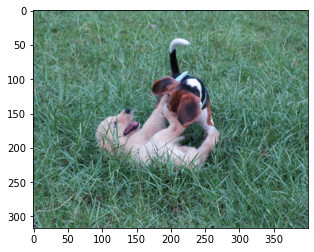

--------------------Predicted--------------------
startseq two dogs are playing in the grass endseq


In [174]:
generate_caption('23445819_3a458716c1.jpg')

---------------------Actual----------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


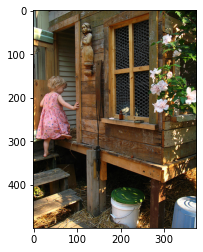

--------------------Predicted--------------------
startseq two girls are sitting in the middle of wooden playhouse endseq


In [176]:
generate_caption('1000268201_693b08cb0e.jpg')

---------------------Actual----------------------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq


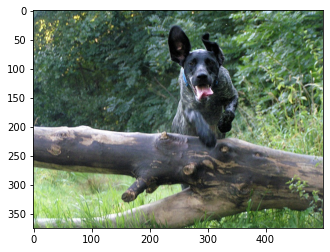

--------------------Predicted--------------------
startseq black dog leaps over log in the woods endseq


In [177]:
generate_caption("1015584366_dfcec3c85a.jpg")

### Generating Caption Using Beam Search

In [185]:
# Example usage with beam_width=3
image_id = '23445819_3a458716c1'
beam_caption = beam_search_caption(model, image_id, features, tokenizer, max_length=max_length, beam_width=3)
print('--------------------Predicted (Beam Search)--------------------')
print(beam_caption)

--------------------Predicted (Beam Search)--------------------
startseq two puppies play in the grass endseq


In [186]:
image_id = '1015584366_dfcec3c85a'
beam_caption = beam_search_caption(model, image_id, features, tokenizer, max_length=max_length, beam_width=3)
print('--------------------Predicted (Beam Search)--------------------')
print(beam_caption)

--------------------Predicted (Beam Search)--------------------
startseq black and black dog jumping over tree stump endseq


### For epochs = 20

In [159]:
from keras.callbacks import EarlyStopping
# train the model
epochs = 20

# Calculate steps for both training and validation sets
train_steps = len(train_data) // batch_size
val_steps = len(val_data) // batch_size

# Training loop
for epoch in range(epochs):
    # Create data generators for training and validation
    train_generator = data_generator(train_ids, train_data, train_features, tokenizer, max_length, vocab_size, batch_size)
    val_generator = data_generator(val_ids, val_data, val_features, tokenizer, max_length, vocab_size, batch_size)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(train_generator, epochs=1, steps_per_epoch=train_steps,
              validation_data=val_generator, validation_steps=val_steps,
              callbacks=[early_stopping], verbose=1)

202/202 [==============================] - 651s 3s/step - loss: 1.7734 - val_loss: 5.1563


In [160]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test_data):
    # get actual caption
    captions = data2[key]
    # predict the caption for image
    y_pred = predict_caption(model, test_features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
#print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|█████████████████████████████████████████| 810/810 [16:35<00:00,  1.23s/it]

BLEU-1: 0.537620


### Here, 54% percentage of the words in the generated caption match those in the reference caption.

In [161]:
def generate_caption(image_name):
    # load the image
    img=cv2.imread("/Users/shalinitandon/Desktop/Fall Sem 3/CS 583/Image Captioning/Dataset/Filckr8k/Images/" + image_name)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    image_id = image_name.split('.')[0]
    captions = data2[image_id]
    print('---------------------Actual----------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    plt.show()
    print('--------------------Predicted--------------------')
    print(y_pred)

---------------------Actual----------------------
startseq beagle and golden retriever wrestling in the grass endseq
startseq two dogs are wrestling in the grass endseq
startseq two puppies are playing in the green grass endseq
startseq two puppies playing around in the grass endseq
startseq two puppies play in the grass endseq


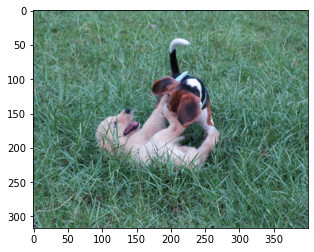

--------------------Predicted--------------------
startseq two puppies playing in the grass endseq


In [165]:
generate_caption("23445819_3a458716c1.jpg")

---------------------Actual----------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


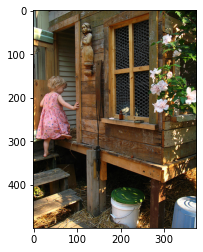

--------------------Predicted--------------------
startseq child in red shirt is standing in the middle of the pool endseq


In [163]:
generate_caption('1000268201_693b08cb0e.jpg')

---------------------Actual----------------------
startseq black dog leaps over log endseq
startseq grey dog is leaping over fallen tree endseq
startseq large black dog leaps fallen log endseq
startseq mottled black and grey dog in blue collar jumping over fallen tree endseq
startseq the black dog jumped the tree stump endseq


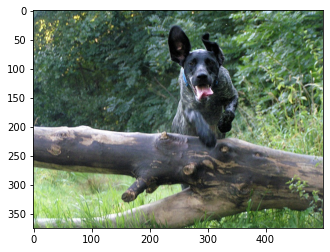

--------------------Predicted--------------------
startseq black dog is digging in the woods endseq


In [164]:
generate_caption("1015584366_dfcec3c85a.jpg")

## Inference

### Greedy search, a score above 0.5 is often considered reasonable, suggesting that the model is capturing some aspects of the desired captions. The slight decrease in BLEU score using greedy search might indicate that the model's performance has plateaued or slightly degraded as training continued. Greedy search selects the most probable word at each step, leading to a sequence of decisions based solely on local optimization. A BLEU score of 0.55 suggests that this approach performs reasonably well in generating captions that align closely with human references.

### Beam search, which explores multiple candidate paths simultaneously, tends to offer a more globally optimized solution. However, in this case, the slightly lower BLEU score (0.43) compared to greedy search could imply that the additional exploration during beam search might not significantly improve the quality of captions, possibly due to model-specific characteristics or the nature of the dataset.

### In summary, while the GREEDY search is currently outperforming BEAM search in terms of BLEU score, further investigation into hyperparameter tuning, model architecture, and potential overfitting is warranted to optimize the performance of both search strategies for enhanced image captioning results.